# NV-Embed for Rocstories

In [1]:
import torch
import torch.nn.functional as F
from transformers import AutoTokenizer, AutoModel
from torch.utils.data import DataLoader
from tqdm import tqdm

In [2]:
model = AutoModel.from_pretrained('nvidia/NV-Embed-v2', trust_remote_code=True)

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

In [3]:
model = model.cuda()

In [4]:
from datasets import load_from_disk

dataset = load_from_disk('/home/jovyan/vmeshchaninov/LatentDiffusion/data/rocstories')

In [11]:
@torch.no_grad()
def get_vectors(texts):
    batch_size = 100

    loader = DataLoader(texts, batch_size=batch_size, shuffle=False)

    vectors = []

    for batch in tqdm(loader):
        output = model.encode(batch, normalize_embeddings=True)
        vectors.extend(output.detach().cpu().tolist())
    return vectors

In [12]:
train_vectors = get_vectors(dataset["train"]["text_trg"])
test_vectors = get_vectors(dataset["test"]["text_trg"])

  0%|          | 0/882 [00:00<?, ?it/s]/home/jovyan/.cache/huggingface/modules/transformers_modules/nvidia/NV-Embed-v2/c50d55f43bde7e6a18e0eaa15a62fd63a930f1a1/modeling_nvembed.py:349: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  'input_ids': torch.tensor(batch_dict.get('input_ids').to(batch_dict.get('input_ids')).long()),
/home/jovyan/.mlspace/envs/dif_env/lib/python3.11/contextlib.py:105: FutureWarning: `torch.backends.cuda.sdp_kernel()` is deprecated. In the future, this context manager will be removed. Please see `torch.nn.attention.sdpa_kernel()` for the new context manager, with updated signature.
  self.gen = func(*args, **kwds)
100%|██████████| 100/100 [01:46<00:00,  1.06s/it]


In [13]:
from datasets import Dataset, DatasetDict

dt = DatasetDict({
    "train": Dataset.from_list([{"latent": latent, "text": text} for latent, text in zip(train_vectors, dataset["train"]["text_trg"])]),
    "test": Dataset.from_list([{"latent": latent, "text": text} for latent, text in zip(test_vectors, dataset["test"]["text_trg"])])
})
dt.save_to_disk(f"./rocstories-latents-NV-Embed-v2")

Saving the dataset (0/6 shards):   0%|          | 0/88161 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/10000 [00:00<?, ? examples/s]

# K-nearest neighbors

In [5]:
import torch
from datasets import Dataset, DatasetDict
from tqdm import tqdm
import numpy as np
from typing import List

from datasets import load_from_disk

In [6]:
nvembed_data = load_from_disk("./rocstories-latents-NV-Embed-v2")
data_v10 = load_from_disk("./rocstories-latents-autoencoder-num_latents=16-wikipedia-v1.0-128")
data_v11 = load_from_disk("./rocstories-latents-autoencoder-num_latents=16-wikipedia-v1.1-128")

Loading dataset from disk:   0%|          | 0/18 [00:00<?, ?it/s]

Loading dataset from disk:   0%|          | 0/18 [00:00<?, ?it/s]

In [15]:
@torch.no_grad()
def batched_pairwise_distance(latent, latents_list, batch_size: int = 100):
    latent = torch.tensor(latent).reshape(1, -1).cuda()
    distances = []
    for i in range(0, len(latents_list), batch_size):
        batch = latents_list[i:i+batch_size]
        batch = torch.tensor(batch).reshape(len(batch), -1).cuda()
        with torch.autocast(device_type='cuda', dtype=torch.bfloat16):
            distances.extend(torch.nn.functional.pairwise_distance(latent, batch).tolist())
    return distances

In [19]:
@torch.no_grad()
def get_nvembed_similarity_for_k_nearest_neighbors(all_nvembed_latents: torch.Tensor, all_latents: torch.Tensor, k: int):
    final_similarities = []

    for i in tqdm(range(len(all_latents))):
        latent = all_latents[i]

        # Get k-nearest neighbors
        distances = torch.nn.functional.pairwise_distance(latent, all_latents)
        k_nearest_indices = torch.argsort(distances)[1:k+1]

        # Get nv_embed_similarity for k-nearest neighbors
        nvembed_latent = all_nvembed_latents[i].cuda()
        k_nearest_nvembed_latents = all_nvembed_latents[k_nearest_indices]
        
        with torch.autocast(device_type='cuda', dtype=torch.bfloat16):
            scores = (nvembed_latent @ k_nearest_nvembed_latents.T) * 100
        final_similarities.extend(scores.detach().cpu().tolist())
        
    return final_similarities


In [25]:
k = 1

In [18]:
all_latents_v10 = torch.tensor(data_v10["test"]["latent"]).reshape(10000, -1).cuda()
all_nvembed_latents = torch.tensor(nvembed_data["test"]["latent"]).cuda()

In [26]:
similarities_v10 = get_nvembed_similarity_for_k_nearest_neighbors(all_nvembed_latents, all_latents_v10, k=k)

100%|██████████| 10000/10000 [00:16<00:00, 612.74it/s]


In [22]:
all_latents_v11 = torch.tensor(data_v11["test"]["latent"]).reshape(10000, -1).cuda()

In [27]:
similarities_v11 = get_nvembed_similarity_for_k_nearest_neighbors(all_nvembed_latents, all_latents_v11, k=k)

100%|██████████| 10000/10000 [00:16<00:00, 613.07it/s]


In [29]:
with torch.autocast(device_type='cuda', dtype=torch.bfloat16):
    scores = (all_nvembed_latents @ all_nvembed_latents.T) * 100

In [34]:
nvembed_sims = torch.sort(scores, dim=1)[0][:, -2]

/tmp/ipykernel_602351/996738239.py:40: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()


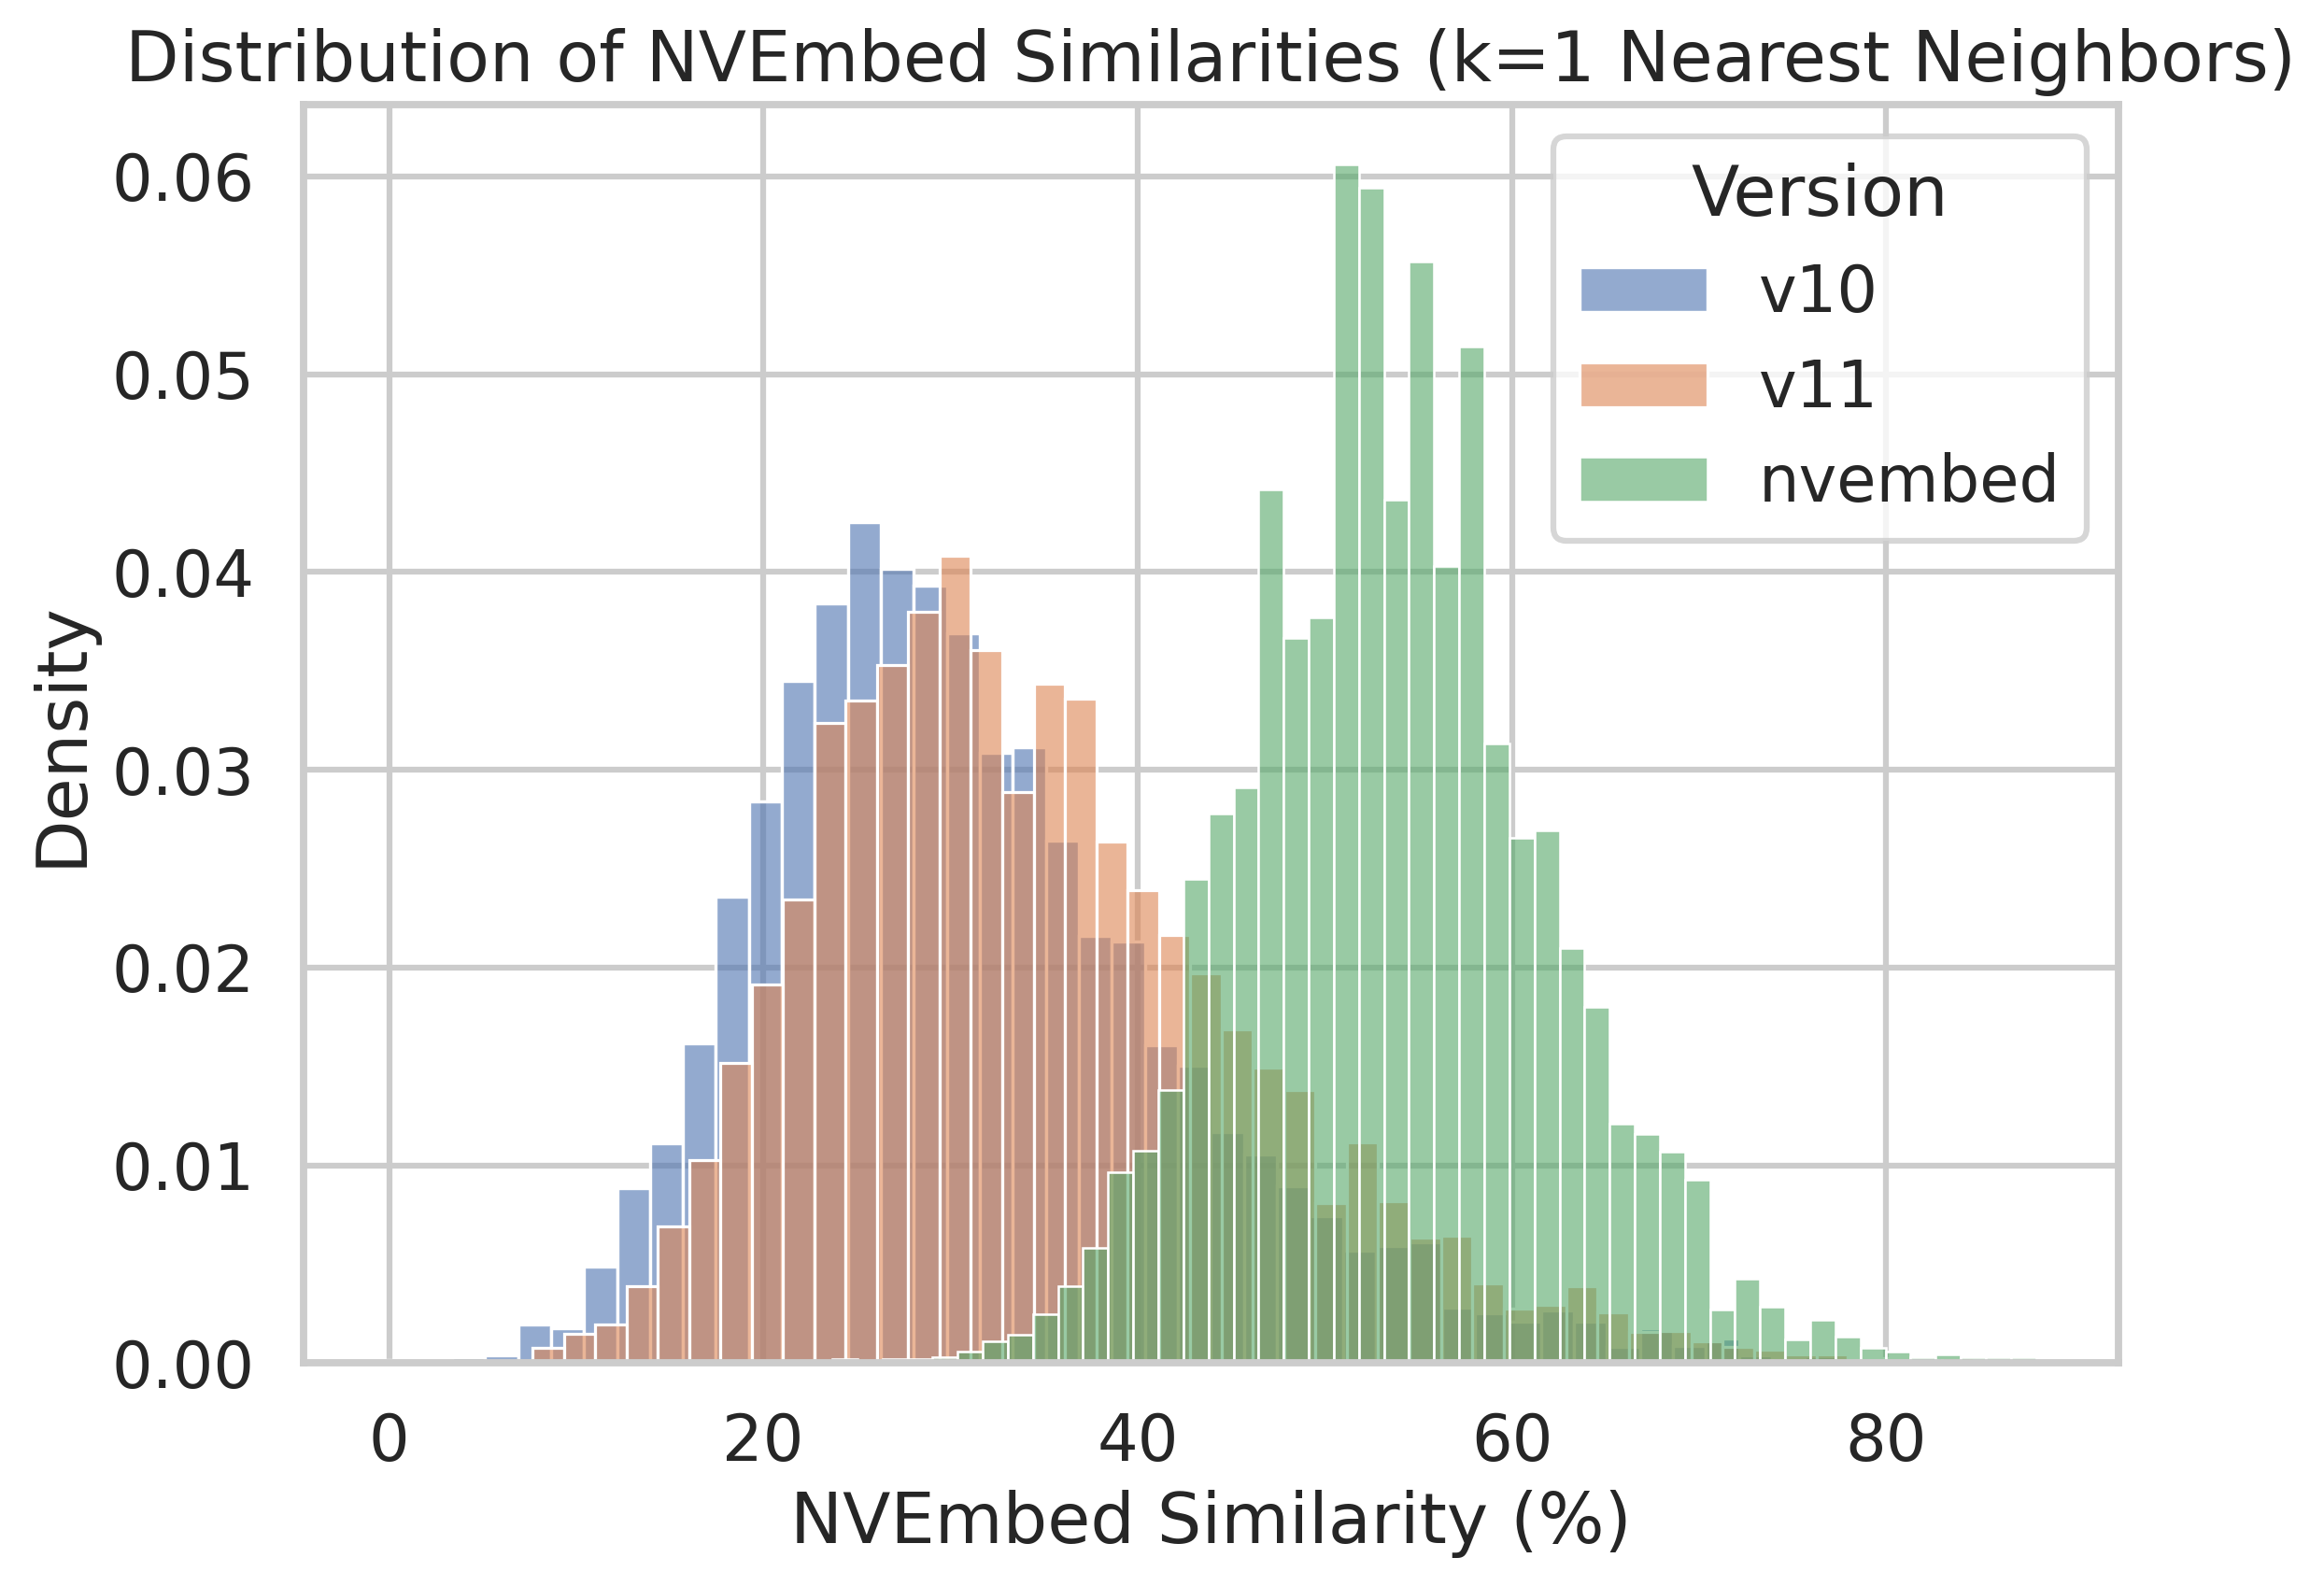

In [37]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set a clean, scientific style
sns.set(style='whitegrid', context='talk')

# Create figure and axis
fig, ax = plt.subplots(figsize=(8, 6), dpi=300)

# Plot histograms for v10 and v11
sns.histplot(similarities_v10,
             bins=50,
             stat='density',
             color='C0',
             alpha=0.6,
             label='v10',
             ax=ax)
sns.histplot(similarities_v11,
             bins=50,
             stat='density',
             color='C1',
             alpha=0.6,
             label='v11',
             ax=ax)
sns.histplot(nvembed_sims.detach().cpu().tolist(),
             bins=50,
             stat='density',
             color='C2',
             alpha=0.6,
             label='nvembed',
             ax=ax)

# Labels, title, legend
ax.set_xlabel('NVEmbed Similarity (%)')
ax.set_ylabel('Density')
ax.set_title(f'Distribution of NVEmbed Similarities (k={k} Nearest Neighbors)')
ax.legend(title='Version')

# Tight layout and show
plt.tight_layout()
plt.show()


In [52]:
distances = torch.tensor([torch.nn.functional.pairwise_distance(latent, all_latents_v11).detach().cpu().tolist() for latent in all_latents_v11])
distances.shape

torch.Size([10000, 10000])

In [53]:
distances = torch.sqrt(distances ** 2 / all_latents_v11.shape[1])

In [54]:
torch.sort(distances, dim=(1))[0][:, 1:5]

tensor([[1.2302, 1.2360, 1.2368, 1.2386],
        [1.2325, 1.2495, 1.2514, 1.2541],
        [1.3270, 1.3284, 1.3356, 1.3397],
        ...,
        [1.2376, 1.2438, 1.2456, 1.2479],
        [1.2486, 1.2494, 1.2709, 1.2717],
        [1.1777, 1.1980, 1.2076, 1.2216]])

# Manifold gravity 

In [1]:
import torch
import torch.nn.functional as F
from transformers import AutoTokenizer, AutoModel
from torch.utils.data import DataLoader
from tqdm import tqdm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns




In [2]:
model = AutoModel.from_pretrained('nvidia/NV-Embed-v2', trust_remote_code=True)

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

In [3]:
model = model.cuda()

In [4]:
data_v10 = pd.read_csv("./bert_score-diffusion-rocstories-16-d=5-v1.0.csv")
data_v11 = pd.read_csv("./bert_score-diffusion-rocstories-16-d=5-v1.1.csv")

In [10]:
@torch.no_grad()
def get_vectors(texts):
    batch_size = 10

    loader = DataLoader(texts[:batch_size], batch_size=batch_size, shuffle=False)

    vectors = []

    for batch in loader:
        output = model.encode(batch, normalize_embeddings=True)
        vectors.extend(output.detach().cpu().tolist())
    return vectors

In [11]:
import ast

@torch.no_grad()
def get_similarity(data):
    similarities = []

    for i in tqdm(range(len(data))):
        pred_text = ast.literal_eval(data.iloc[i]["pred_text"])
        trg_text = ast.literal_eval(data.iloc[i]["trg_text"])

        pred_latent = torch.tensor(get_vectors(pred_text)).cuda()
        trg_latent = torch.tensor(get_vectors(trg_text)).cuda()

        similarity = torch.sum(pred_latent * trg_latent, dim=1).mean()
        similarities.append(similarity.item())
    
    return similarities

In [12]:
@torch.no_grad()
def get_random_similarity(data):
    similarities = []

    for i in tqdm(range(len(data))):
        pred_text = ast.literal_eval(data.iloc[i]["pred_text"])
        trg_text = ast.literal_eval(data.iloc[i]["trg_text"])
        import random
        # create a derangement of trg_text so no element stays at its original index
        deranged = trg_text.copy()
        while True:
            random.shuffle(deranged)
            if all(deranged[i] != trg_text[i] for i in range(len(trg_text))):
                break
        trg_text = deranged

        pred_latent = torch.tensor(get_vectors(pred_text)).cuda()
        trg_latent = torch.tensor(get_vectors(trg_text)).cuda()

        similarity = torch.sum(pred_latent * trg_latent, dim=1).mean()
        similarities.append(similarity.item())
    
    return similarities

In [13]:
data_v10["similarity"] = get_similarity(data_v10)
data_v11["similarity"] = get_similarity(data_v11)


  0%|          | 0/100 [00:00<?, ?it/s]/home/jovyan/.cache/huggingface/modules/transformers_modules/nvidia/NV-Embed-v2/c50d55f43bde7e6a18e0eaa15a62fd63a930f1a1/modeling_nvembed.py:349: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  'input_ids': torch.tensor(batch_dict.get('input_ids').to(batch_dict.get('input_ids')).long()),
/home/jovyan/.mlspace/envs/dif_env/lib/python3.11/contextlib.py:105: FutureWarning: `torch.backends.cuda.sdp_kernel()` is deprecated. In the future, this context manager will be removed. Please see `torch.nn.attention.sdpa_kernel()` for the new context manager, with updated signature.
  self.gen = func(*args, **kwds)
  0%|          | 0/100 [00:00<?, ?it/s]/home/jovyan/.cache/huggingface/modules/transformers_modules/nvidia/NV-Embed-v2/c50d55f43bde7e6a18e0eaa15a62fd63a930f1a1/modeling_nvembed.py:349: UserWarning: To co

In [14]:
data_v10["random_similarity"] = get_random_similarity(data_v10)
data_v11["random_similarity"] = get_random_similarity(data_v11)


  0%|          | 0/100 [00:00<?, ?it/s]/home/jovyan/.cache/huggingface/modules/transformers_modules/nvidia/NV-Embed-v2/c50d55f43bde7e6a18e0eaa15a62fd63a930f1a1/modeling_nvembed.py:349: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  'input_ids': torch.tensor(batch_dict.get('input_ids').to(batch_dict.get('input_ids')).long()),
/home/jovyan/.mlspace/envs/dif_env/lib/python3.11/contextlib.py:105: FutureWarning: `torch.backends.cuda.sdp_kernel()` is deprecated. In the future, this context manager will be removed. Please see `torch.nn.attention.sdpa_kernel()` for the new context manager, with updated signature.
  self.gen = func(*args, **kwds)
  0%|          | 0/100 [00:00<?, ?it/s]/home/jovyan/.cache/huggingface/modules/transformers_modules/nvidia/NV-Embed-v2/c50d55f43bde7e6a18e0eaa15a62fd63a930f1a1/modeling_nvembed.py:349: UserWarning: To co

In [16]:
data_v10.to_csv("./results/manifold_gravity/similarity-v1.0.csv", index=False)
data_v11.to_csv("./results/manifold_gravity/similarity-v1.1.csv", index=False)


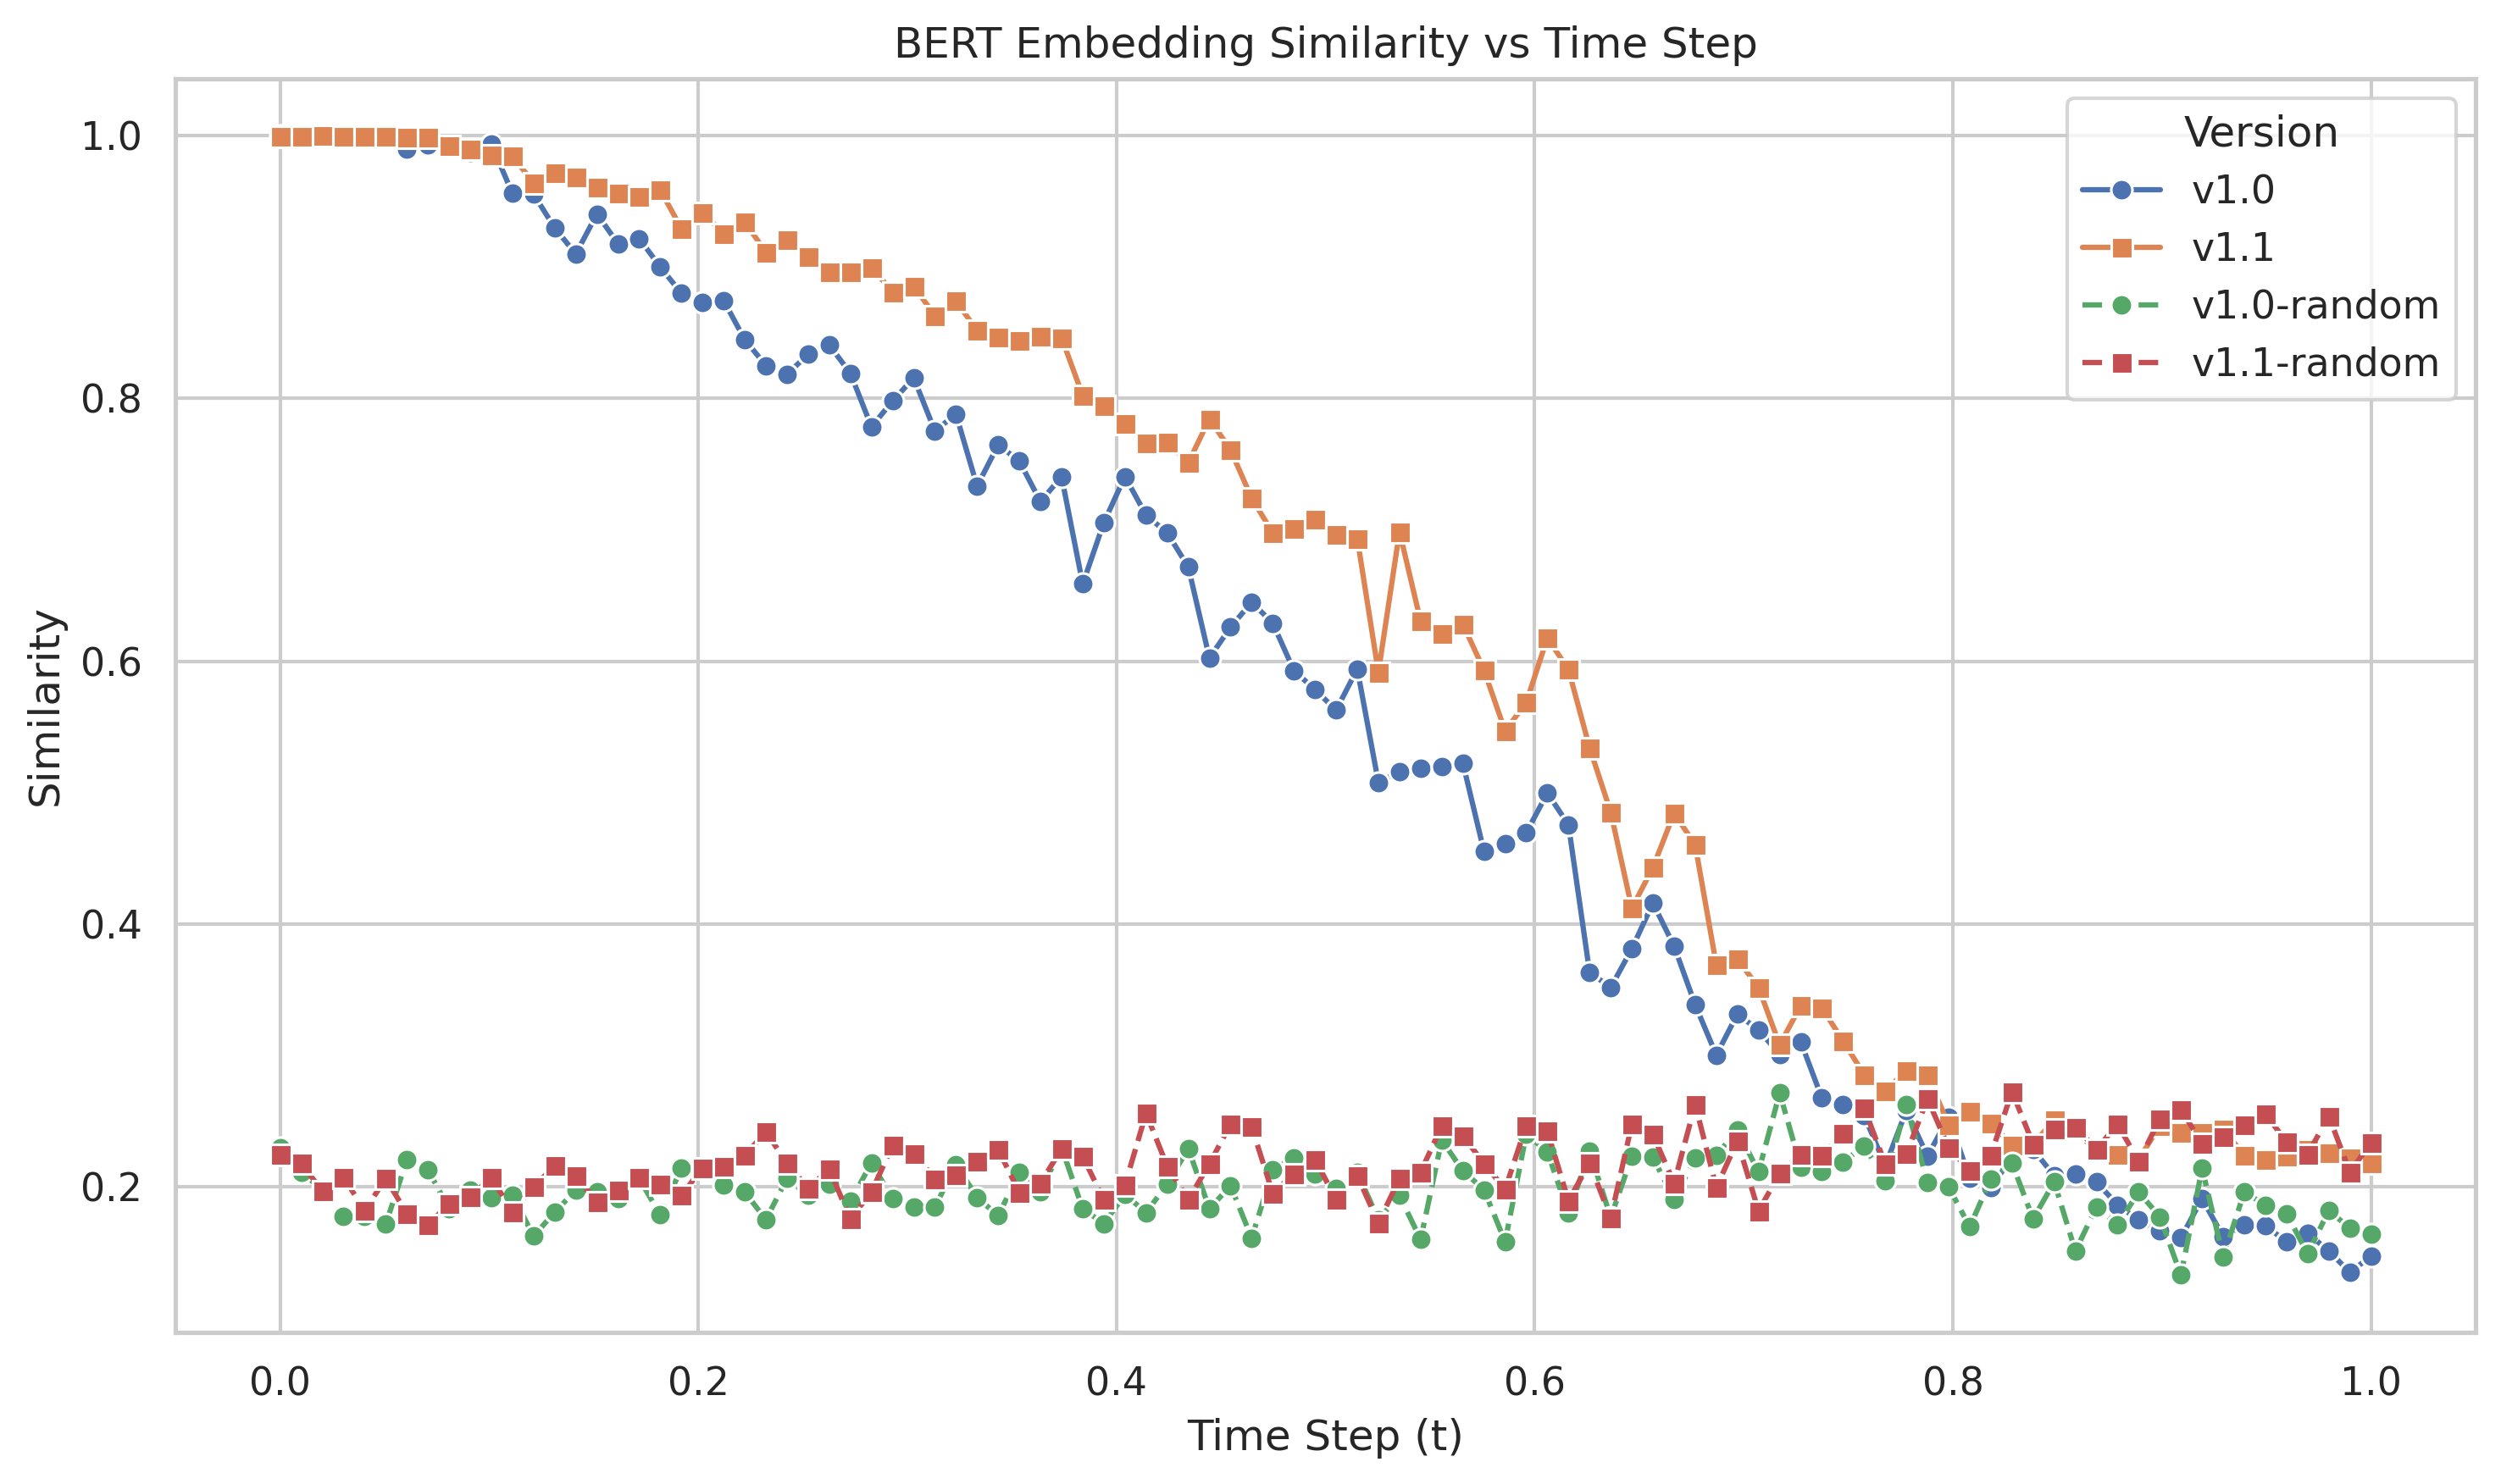

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme(style="whitegrid")

plt.figure(figsize=(10, 6), dpi=300)
sns.lineplot(data=data_v10, x="t", y="similarity", label="v1.0", marker="o")
sns.lineplot(data=data_v11, x="t", y="similarity", label="v1.1", marker="s")

sns.lineplot(data=data_v10, x="t", y="random_similarity", label="v1.0-random", marker="o", linestyle="--")
sns.lineplot(data=data_v11, x="t", y="random_similarity", label="v1.1-random", marker="s", linestyle="--")

plt.title("BERT Embedding Similarity vs Time Step")
plt.xlabel("Time Step (t)")
plt.ylabel("Similarity")
plt.legend(title="Version")
plt.tight_layout()
plt.show()

# PPL

In [51]:
import os
import sys


PROJECT_ROOT = "/home/jovyan/vmeshchaninov/LatentDiffusion"
sys.path.append(PROJECT_ROOT)
os.environ["PROJECT_ROOT"] = PROJECT_ROOT

In [57]:
from evaluate import load

In [68]:
import ast

@torch.no_grad()
def get_ppl(data):
    model_id = 'gpt2-large'
    perplexity = load("perplexity", module_type="metric", model_id=model_id)

    ppls = []

    texts = []
    batch_size = 100

    end_indices = [0]

    for i in tqdm(range(len(data))):
        pred_text = ast.literal_eval(data.iloc[i]["pred_text"])
        pred_text = [t for t in pred_text if t != ""]
        texts.extend(pred_text[:batch_size])
        end_indices.append(len(texts))

    ppl = perplexity.compute(
        predictions=texts, 
        model_id=model_id, 
        device='cuda', 
        add_start_token=True,
    )["perplexities"]

    ppls = [np.mean(ppl[s:e]) for s, e in zip(end_indices[:-1], end_indices[1:])]
    
    return ppls

In [69]:
data_v10["ppl"] = get_ppl(data_v10)
data_v11["ppl"] = get_ppl(data_v11)


100%|██████████| 100/100 [00:00<00:00, 475.52it/s]


  0%|          | 0/625 [00:00<?, ?it/s]

100%|██████████| 100/100 [00:00<00:00, 464.11it/s]


  0%|          | 0/625 [00:00<?, ?it/s]

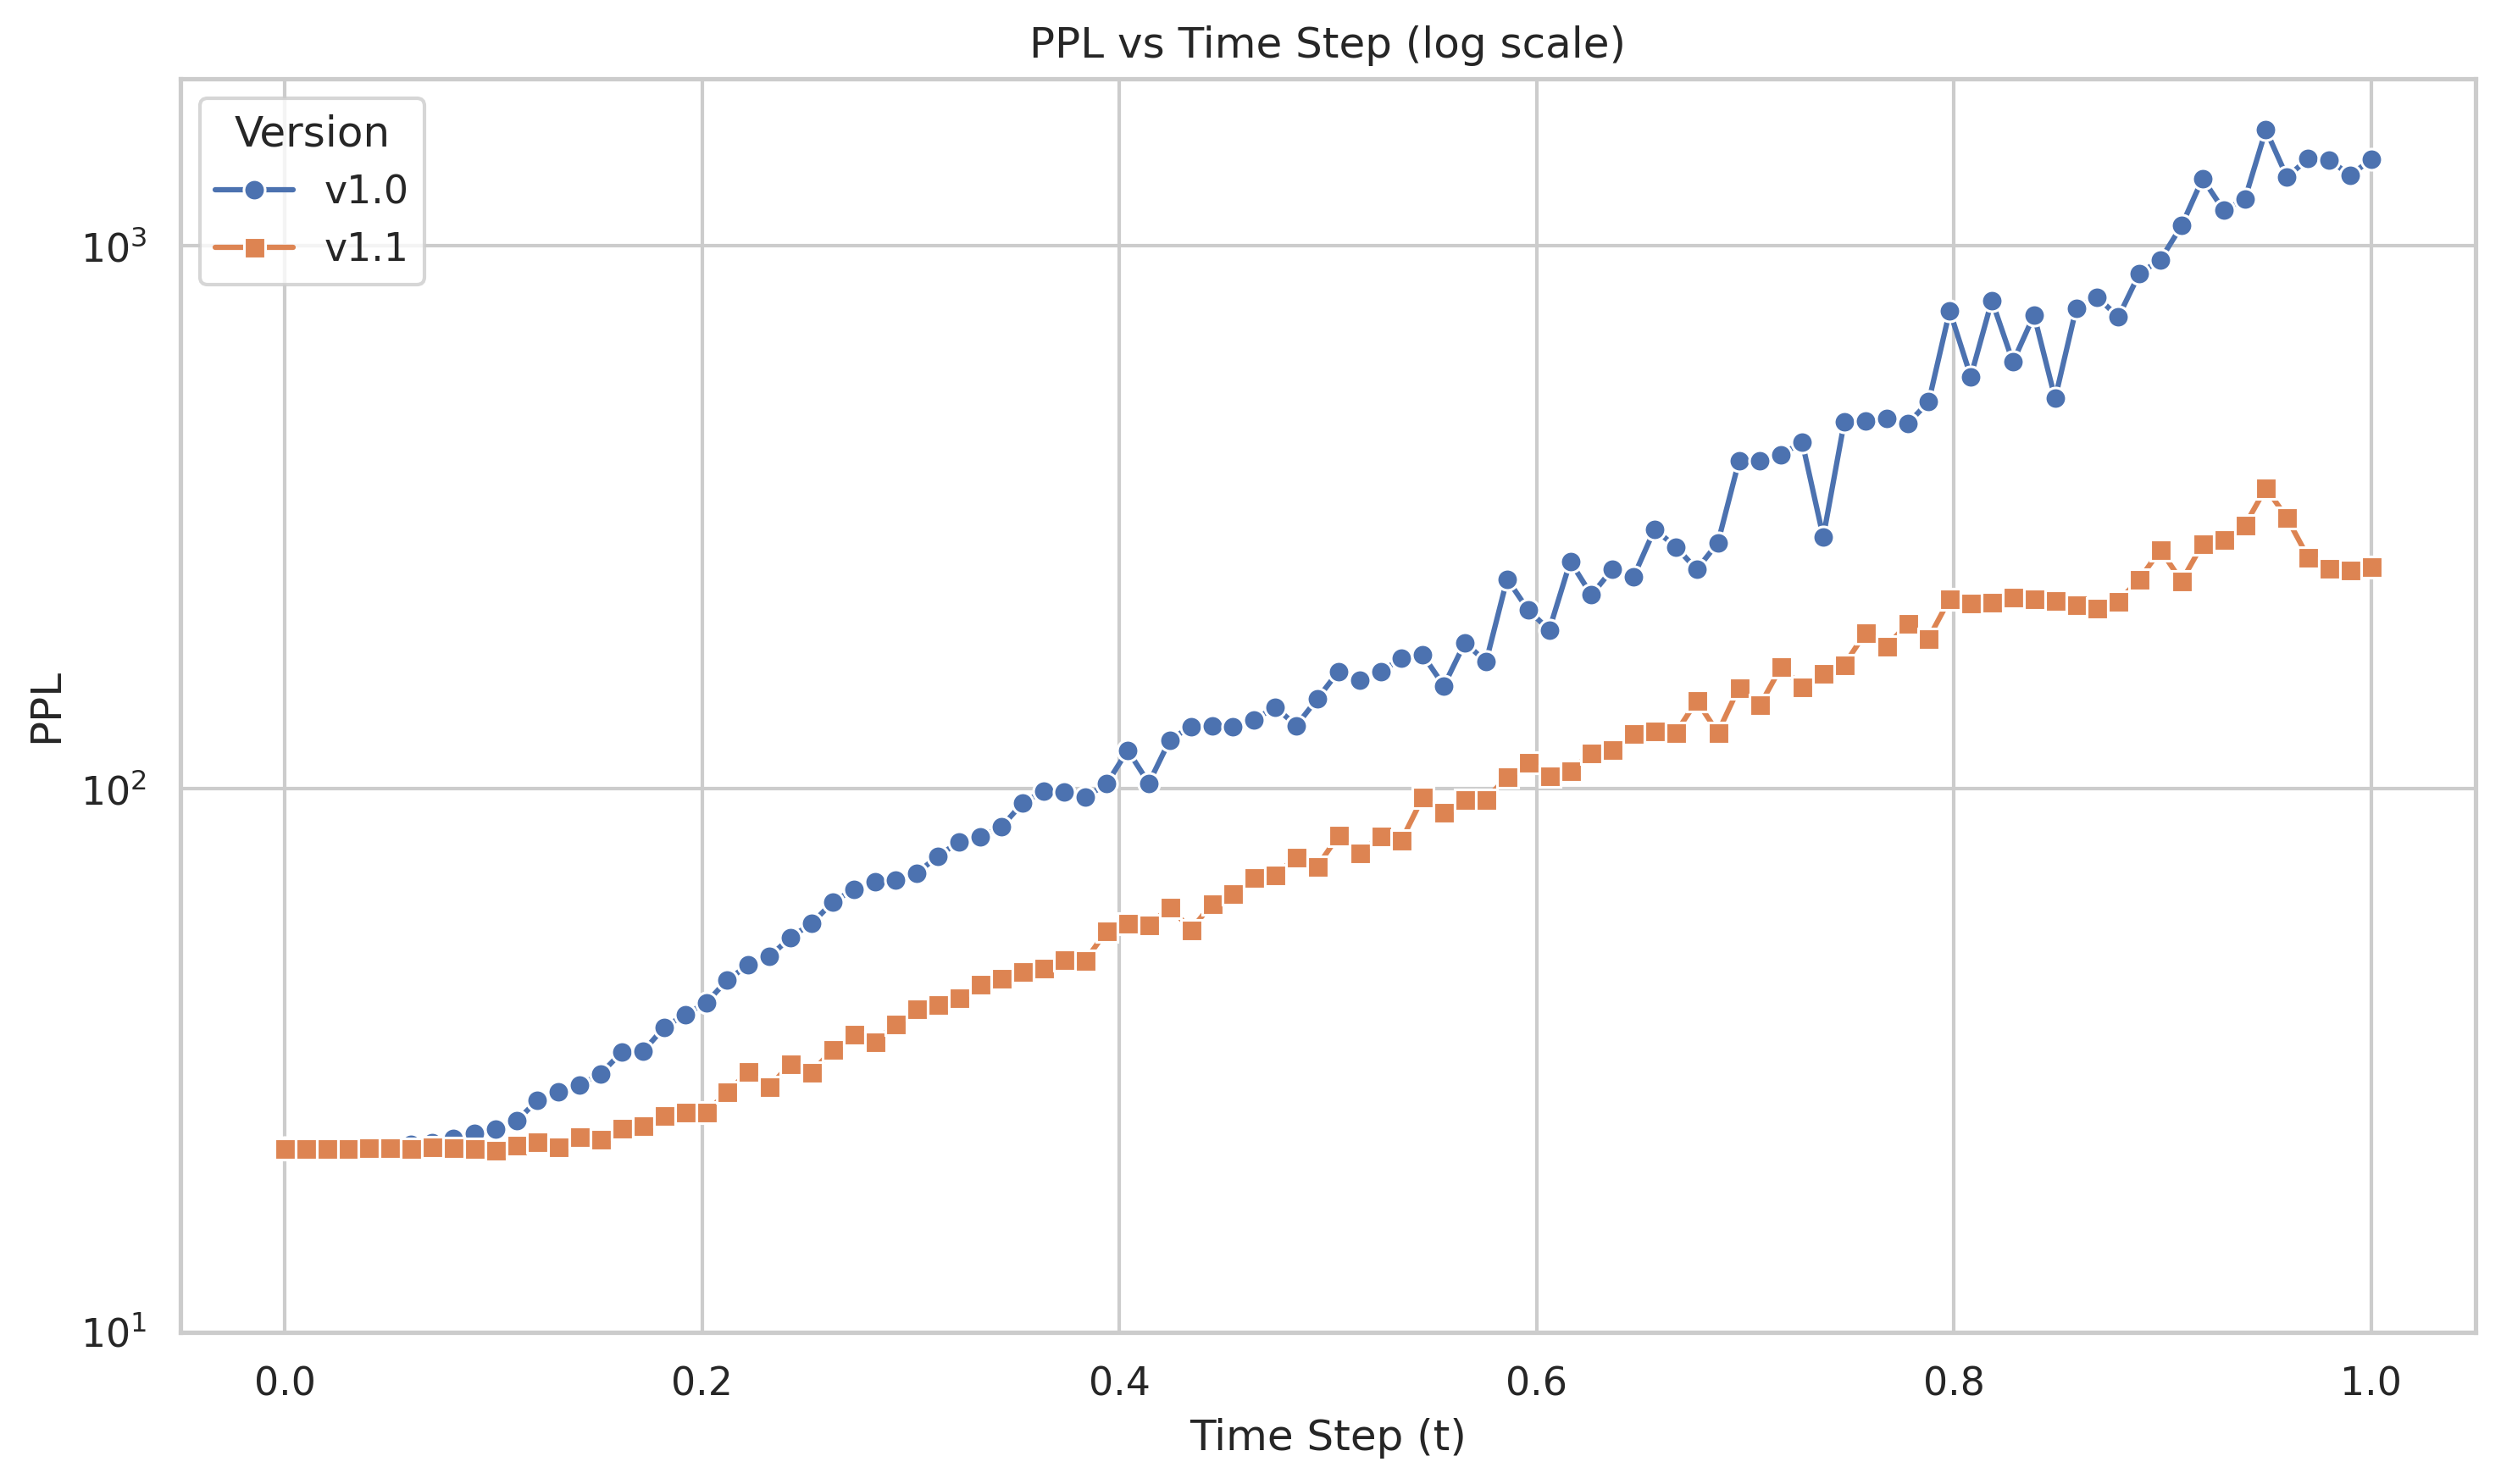

In [72]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme(style="whitegrid")

plt.figure(figsize=(10, 6), dpi=300)
sns.lineplot(data=data_v10, x="t", y="ppl", label="v1.0", marker="o")
sns.lineplot(data=data_v11, x="t", y="ppl", label="v1.1", marker="s")
plt.yscale('log')
plt.ylim(bottom=1e1)  # start y-axis at 10^1
plt.title("PPL vs Time Step (log scale)")
plt.xlabel("Time Step (t)")
plt.ylabel("PPL")
plt.legend(title="Version")
plt.tight_layout()
plt.show()

# Interpolation

In [73]:
import torch
import torch.nn.functional as F
from transformers import AutoTokenizer, AutoModel
from torch.utils.data import DataLoader
from tqdm import tqdm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from evaluate import load



In [94]:
data_v10_interpolation = pd.read_csv("./interpolation-diffusion-rocstories-16-d=5-v1.0-t=0.1.csv")
data_v11_interpolation = pd.read_csv("./interpolation-diffusion-rocstories-16-d=5-v1.1-t=0.1.csv")
# data_v11_interpolation = pd.read_csv("./interpolation-diffusion-rocstories-16-d=5-v1.1-pixel_masking-prob_0.3-t=0.1.csv")

In [106]:
import ast

@torch.no_grad()
def get_ppl(data):
    model_id = 'gpt2-large'
    perplexity = load("perplexity", module_type="metric", model_id=model_id)

    ppls = []

    texts = []
    batch_size = 100

    end_indices = [0]

    for i in tqdm(range(len(data))):
        pred_text = ast.literal_eval(data.iloc[i]["pred_text"])
        pred_text = [t for t in pred_text if t != ""]
        texts.extend(pred_text[:batch_size])
        end_indices.append(len(texts))

    ppl = perplexity.compute(
        predictions=texts, 
        model_id=model_id, 
        device='cuda', 
        add_start_token=True,
    )["perplexities"]

    ppls = [ppl[s:e] for s, e in zip(end_indices[:-1], end_indices[1:])]
    
    return ppls

In [107]:
data_v10_interpolation["ppl"] = get_ppl(data_v10_interpolation)
data_v11_interpolation["ppl"] = get_ppl(data_v11_interpolation)


100%|██████████| 100/100 [00:00<00:00, 3505.95it/s]


  0%|          | 0/625 [00:00<?, ?it/s]

100%|██████████| 100/100 [00:00<00:00, 3402.18it/s]


  0%|          | 0/625 [00:00<?, ?it/s]

In [108]:
data_v10_interpolation.to_csv("./results/interpolation/interpolation-v1.0-t=0.1.csv", index=False)
data_v11_interpolation.to_csv("./results/interpolation/interpolation-v1.1-t=0.1.csv", index=False)

In [117]:
def filter_ppl(ppl_list):
    ppl_list = np.sort(ppl_list)
    quantile = 0.1
    a_min, a_max = int(quantile * len(ppl_list)), int((1 - quantile) * len(ppl_list))
    ppl_list = ppl_list[a_min: a_max]
    ppl = np.mean(ppl_list)
    return ppl

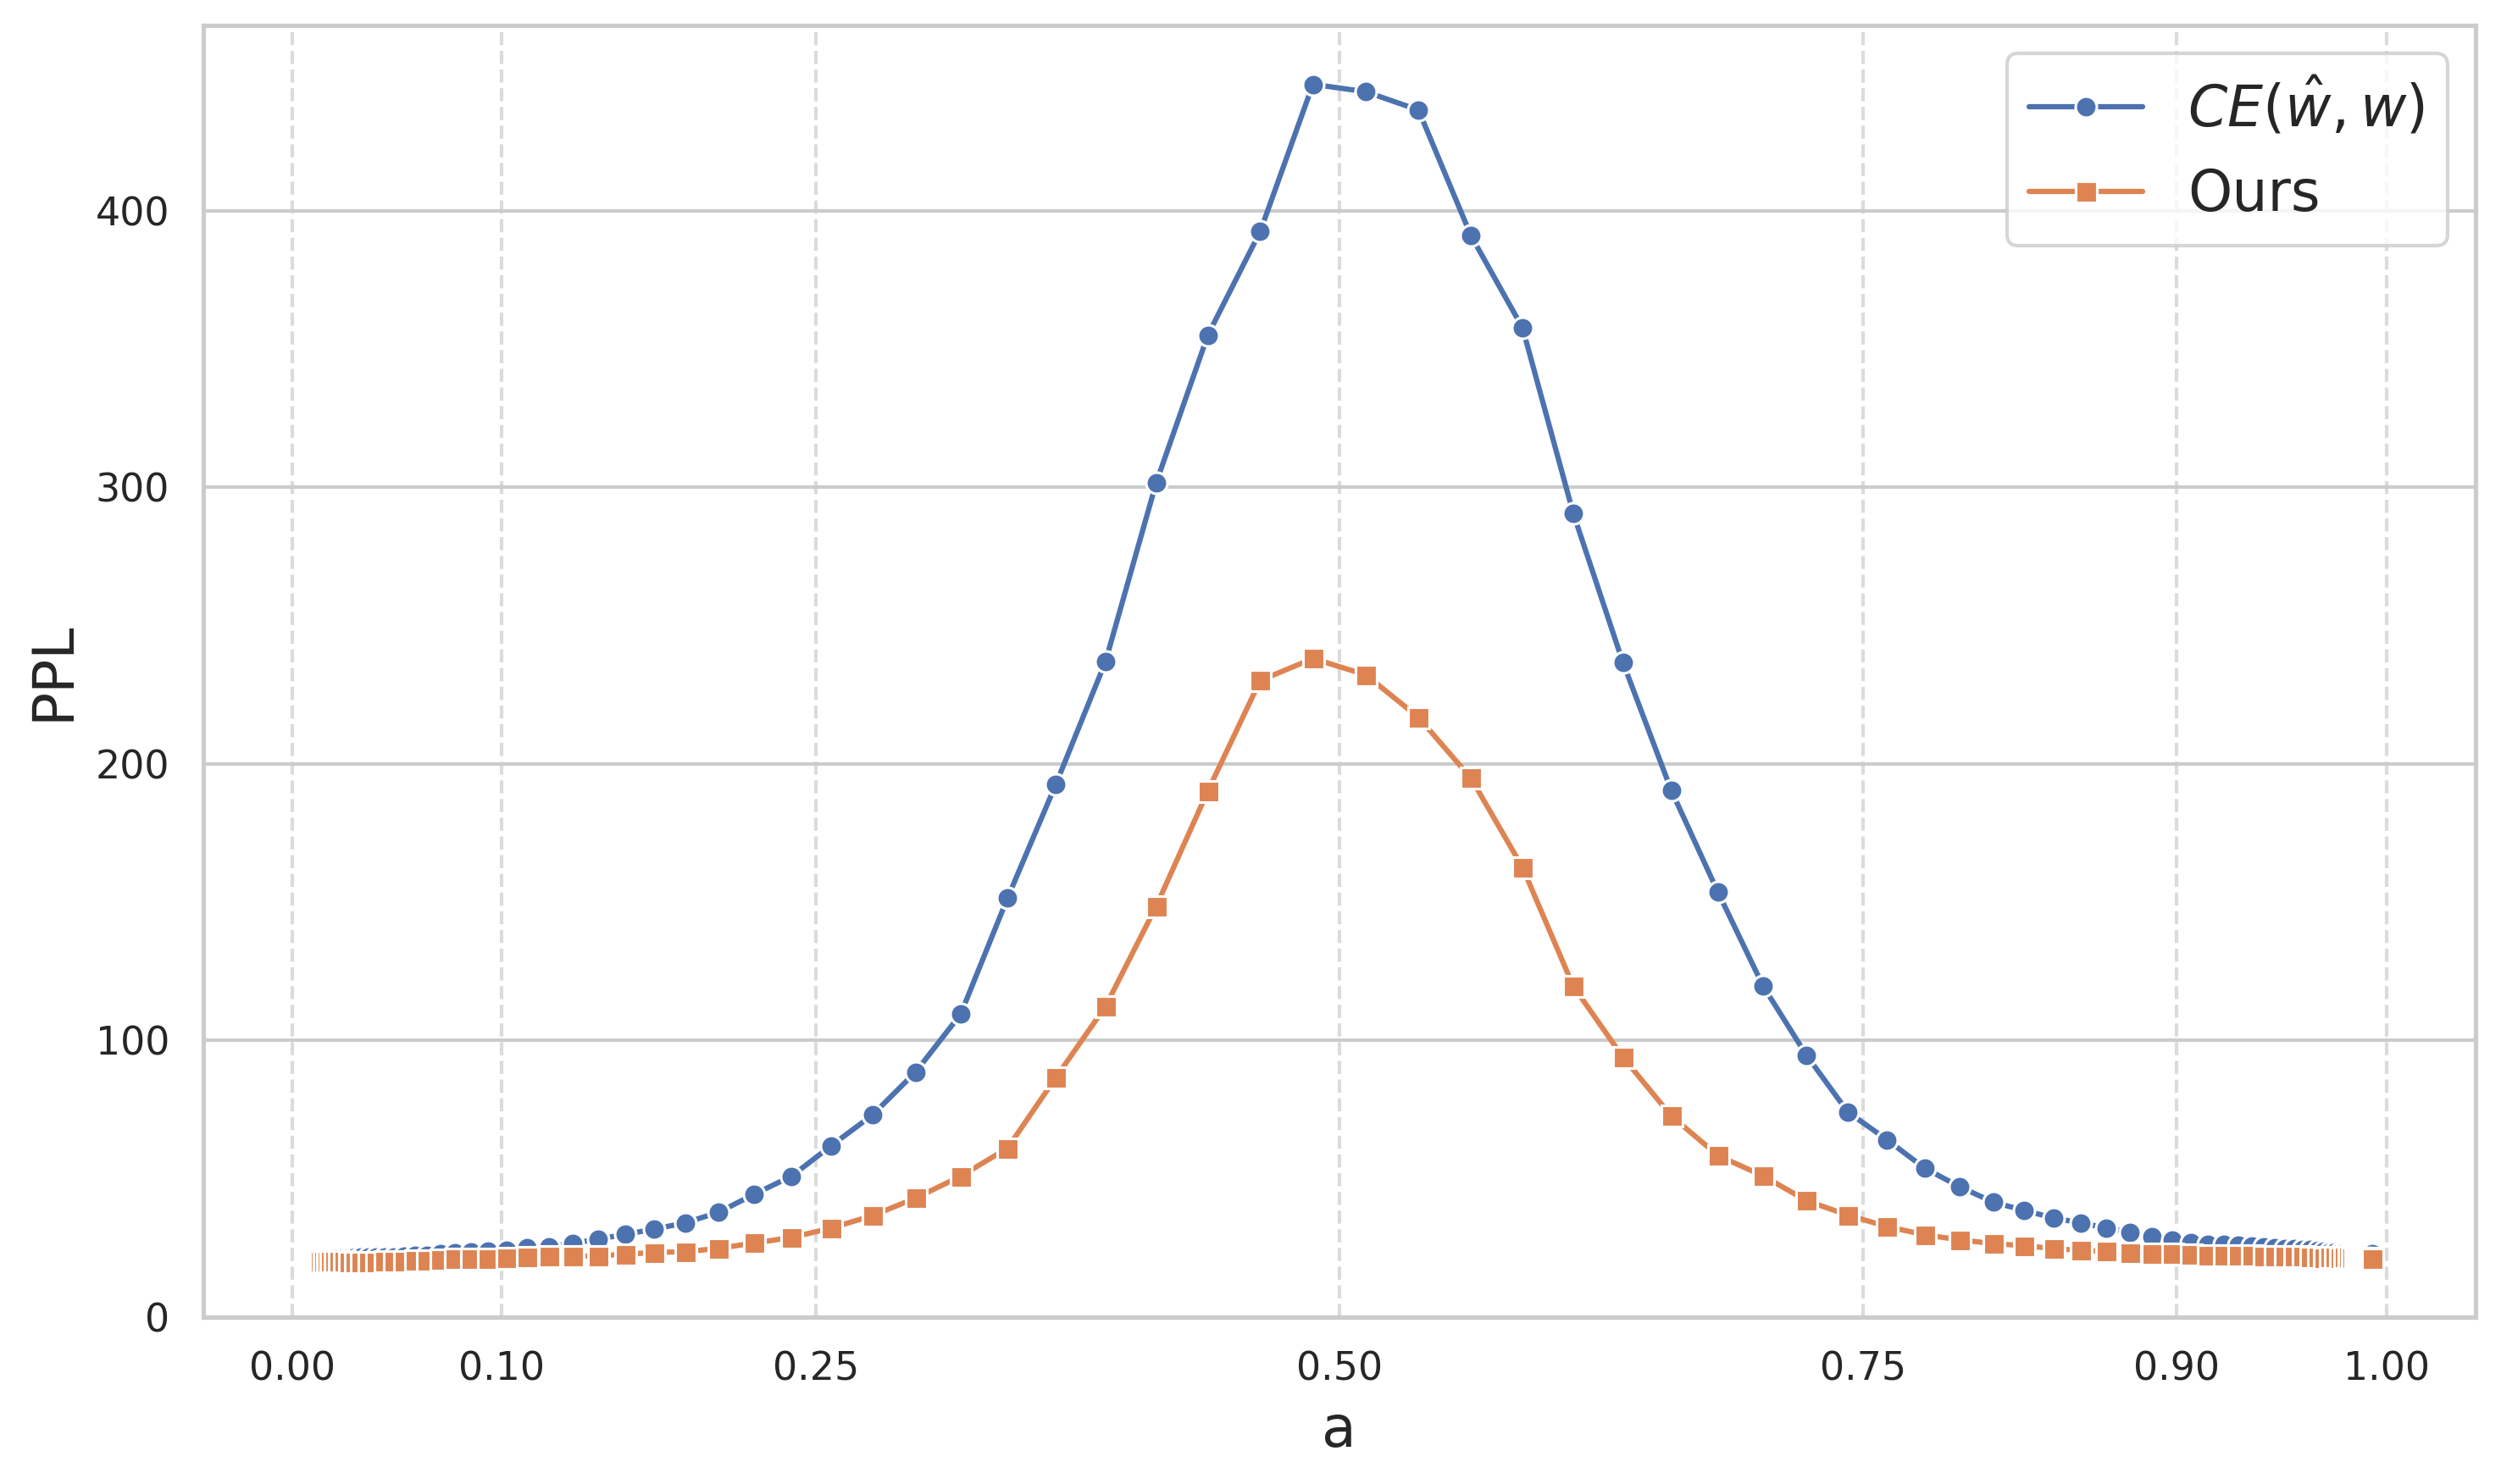

In [123]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme(style="whitegrid")

# take the original, evenly‐spaced alpha grid
alpha_orig = data_v10_interpolation['alpha'].values

# warp it so points cluster near 0 and 1 (cosine‐based transform)
c = 10
alpha_warp = 1 / (1 + np.exp(-c * (alpha_orig - 0.5)))

ppl_v10 = [np.mean(filter_ppl(ppl)) for ppl in data_v10_interpolation['ppl'].values]
ppl_v11 = [np.mean(filter_ppl(ppl)) for ppl in data_v11_interpolation['ppl'].values]

# plot in the original sequence (no sorting), but using warped x‐positions
plt.figure(figsize=(10, 6), dpi=300)
sns.lineplot(x=alpha_warp, y=ppl_v10, label='$CE(\hat{w}, w)$', marker='o', sort=False)
sns.lineplot(x=alpha_warp, y=ppl_v11, label='Ours', marker='s', sort=False)
plt.ylim(bottom=1e1)  # start y-axis at 10^1
# plt.title("PPL vs warped alpha (denser at borders), t=0.1")
plt.xlabel("a", fontsize=16)
plt.ylabel("PPL", fontsize=16)
plt.legend(fontsize=16)
# set x-axis ticks to warped alpha values and enable vertical grid lines

xticks = np.linspace(0, 1, 100)
plt.xticks(xticks)
plt.grid(axis='x', linestyle='--', alpha=0.7)

plt.ylim(bottom=0)

xticks = [0.0, 0.1, 0.25, 0.5, 0.75, 0.9, 1.0]
plt.xticks(xticks)

plt.tight_layout()
plt.show()

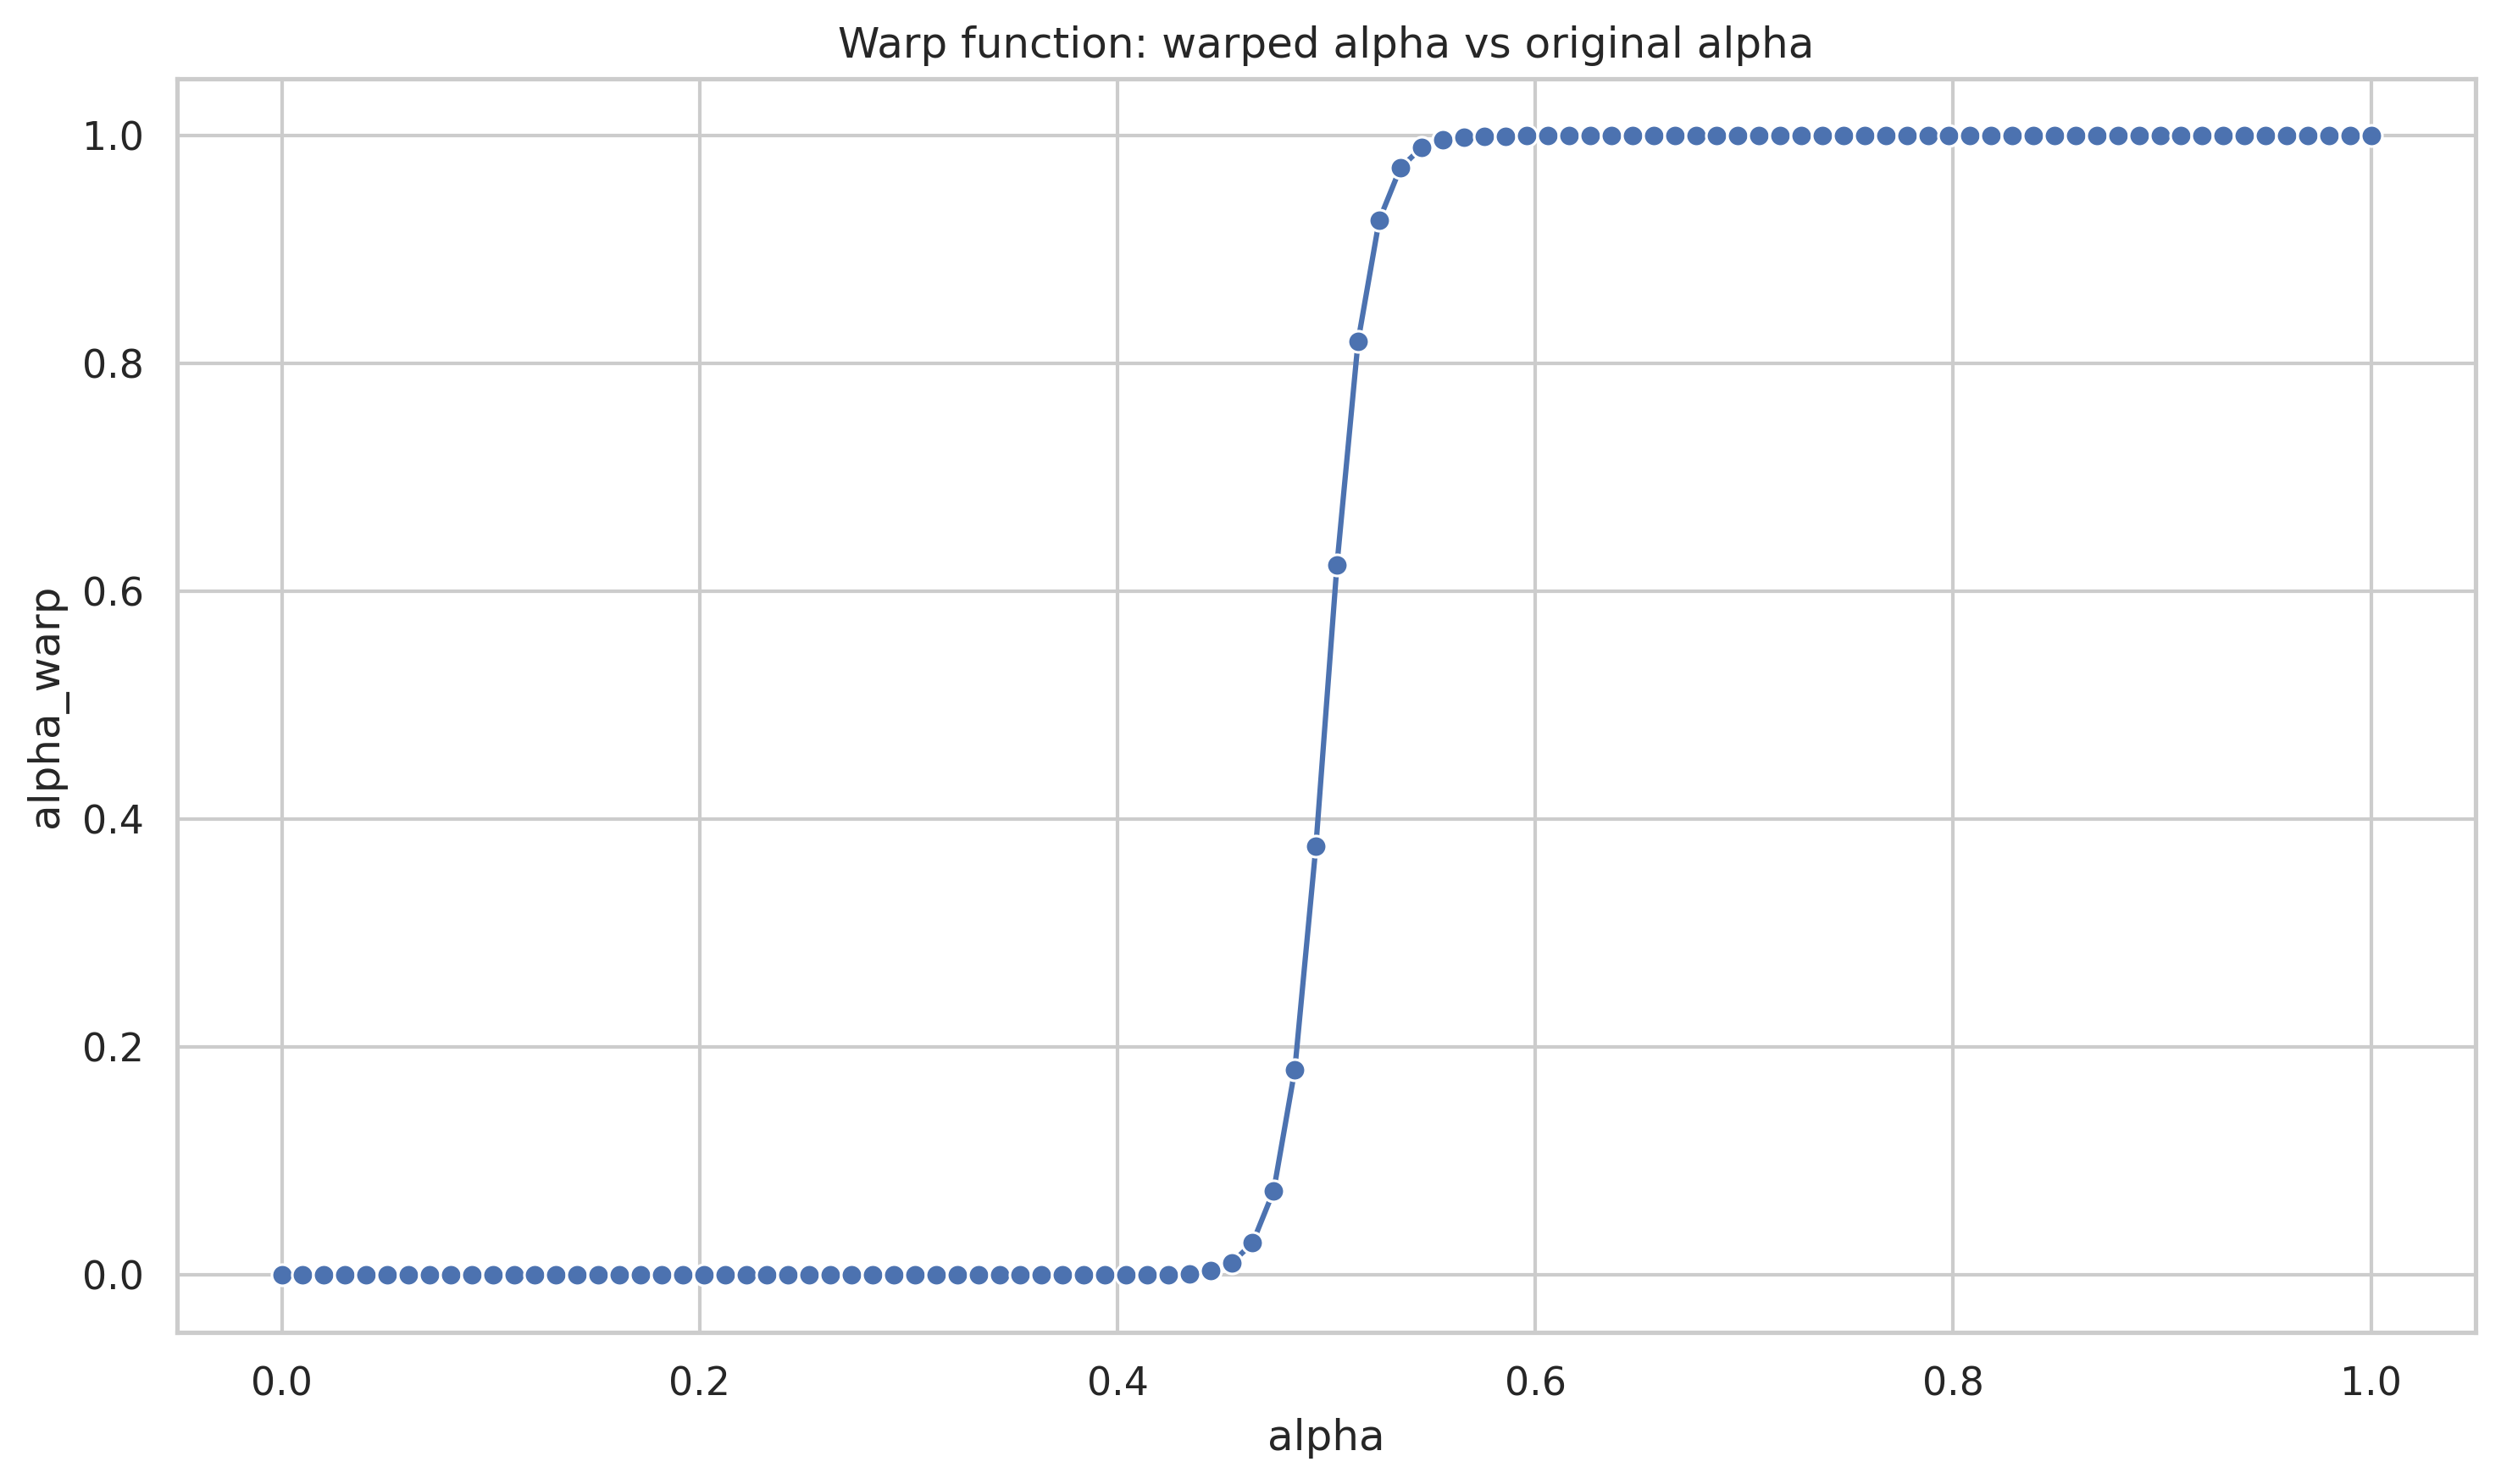

In [23]:
# Compute warped alpha mapping from the original alpha grid
alpha_orig = data_v10_interpolation["alpha"].values
c = 100
alpha_warp = 1 / (1 + np.exp(-c * (alpha_orig - 0.5)))

plt.figure(figsize=(10, 6), dpi=300)
sns.lineplot(x=alpha_orig, y=alpha_warp, marker="o", sort=False)
plt.title("Warp function: warped alpha vs original alpha")
plt.xlabel("alpha")
plt.ylabel("alpha_warp")
plt.tight_layout()
plt.show()


# DDIM generation

In [90]:
data_v10_ddim = pd.read_csv("./ddim_generation-diffusion-rocstories-16-d=5-v1.0.csv")
data_v11_ddim = pd.read_csv("./ddim_generation-diffusion-rocstories-16-d=5-v1.1.csv")

In [91]:
import ast

@torch.no_grad()
def get_ppl(data):
    model_id = 'gpt2-large'
    perplexity = load("perplexity", module_type="metric", model_id=model_id)

    ppls = []

    texts = []
    batch_size = 100

    end_indices = [0]

    for i in tqdm(range(len(data))):
        pred_text = ast.literal_eval(data.iloc[i]["pred_text"])
        pred_text = [t for t in pred_text if t != ""]
        texts.extend(pred_text[:batch_size])
        end_indices.append(len(texts))

    ppl = perplexity.compute(
        predictions=texts, 
        model_id=model_id, 
        device='cuda', 
        add_start_token=True,
    )["perplexities"]

    ppls = [np.mean(ppl[s:e]) for s, e in zip(end_indices[:-1], end_indices[1:])]
    
    return ppls

In [92]:
data_v10_ddim["ppl"] = get_ppl(data_v10_ddim)
data_v11_ddim["ppl"] = get_ppl(data_v11_ddim)


100%|██████████| 199/199 [00:00<00:00, 3268.29it/s]


  0%|          | 0/1244 [00:00<?, ?it/s]

100%|██████████| 199/199 [00:00<00:00, 3093.00it/s]


  0%|          | 0/1244 [00:00<?, ?it/s]

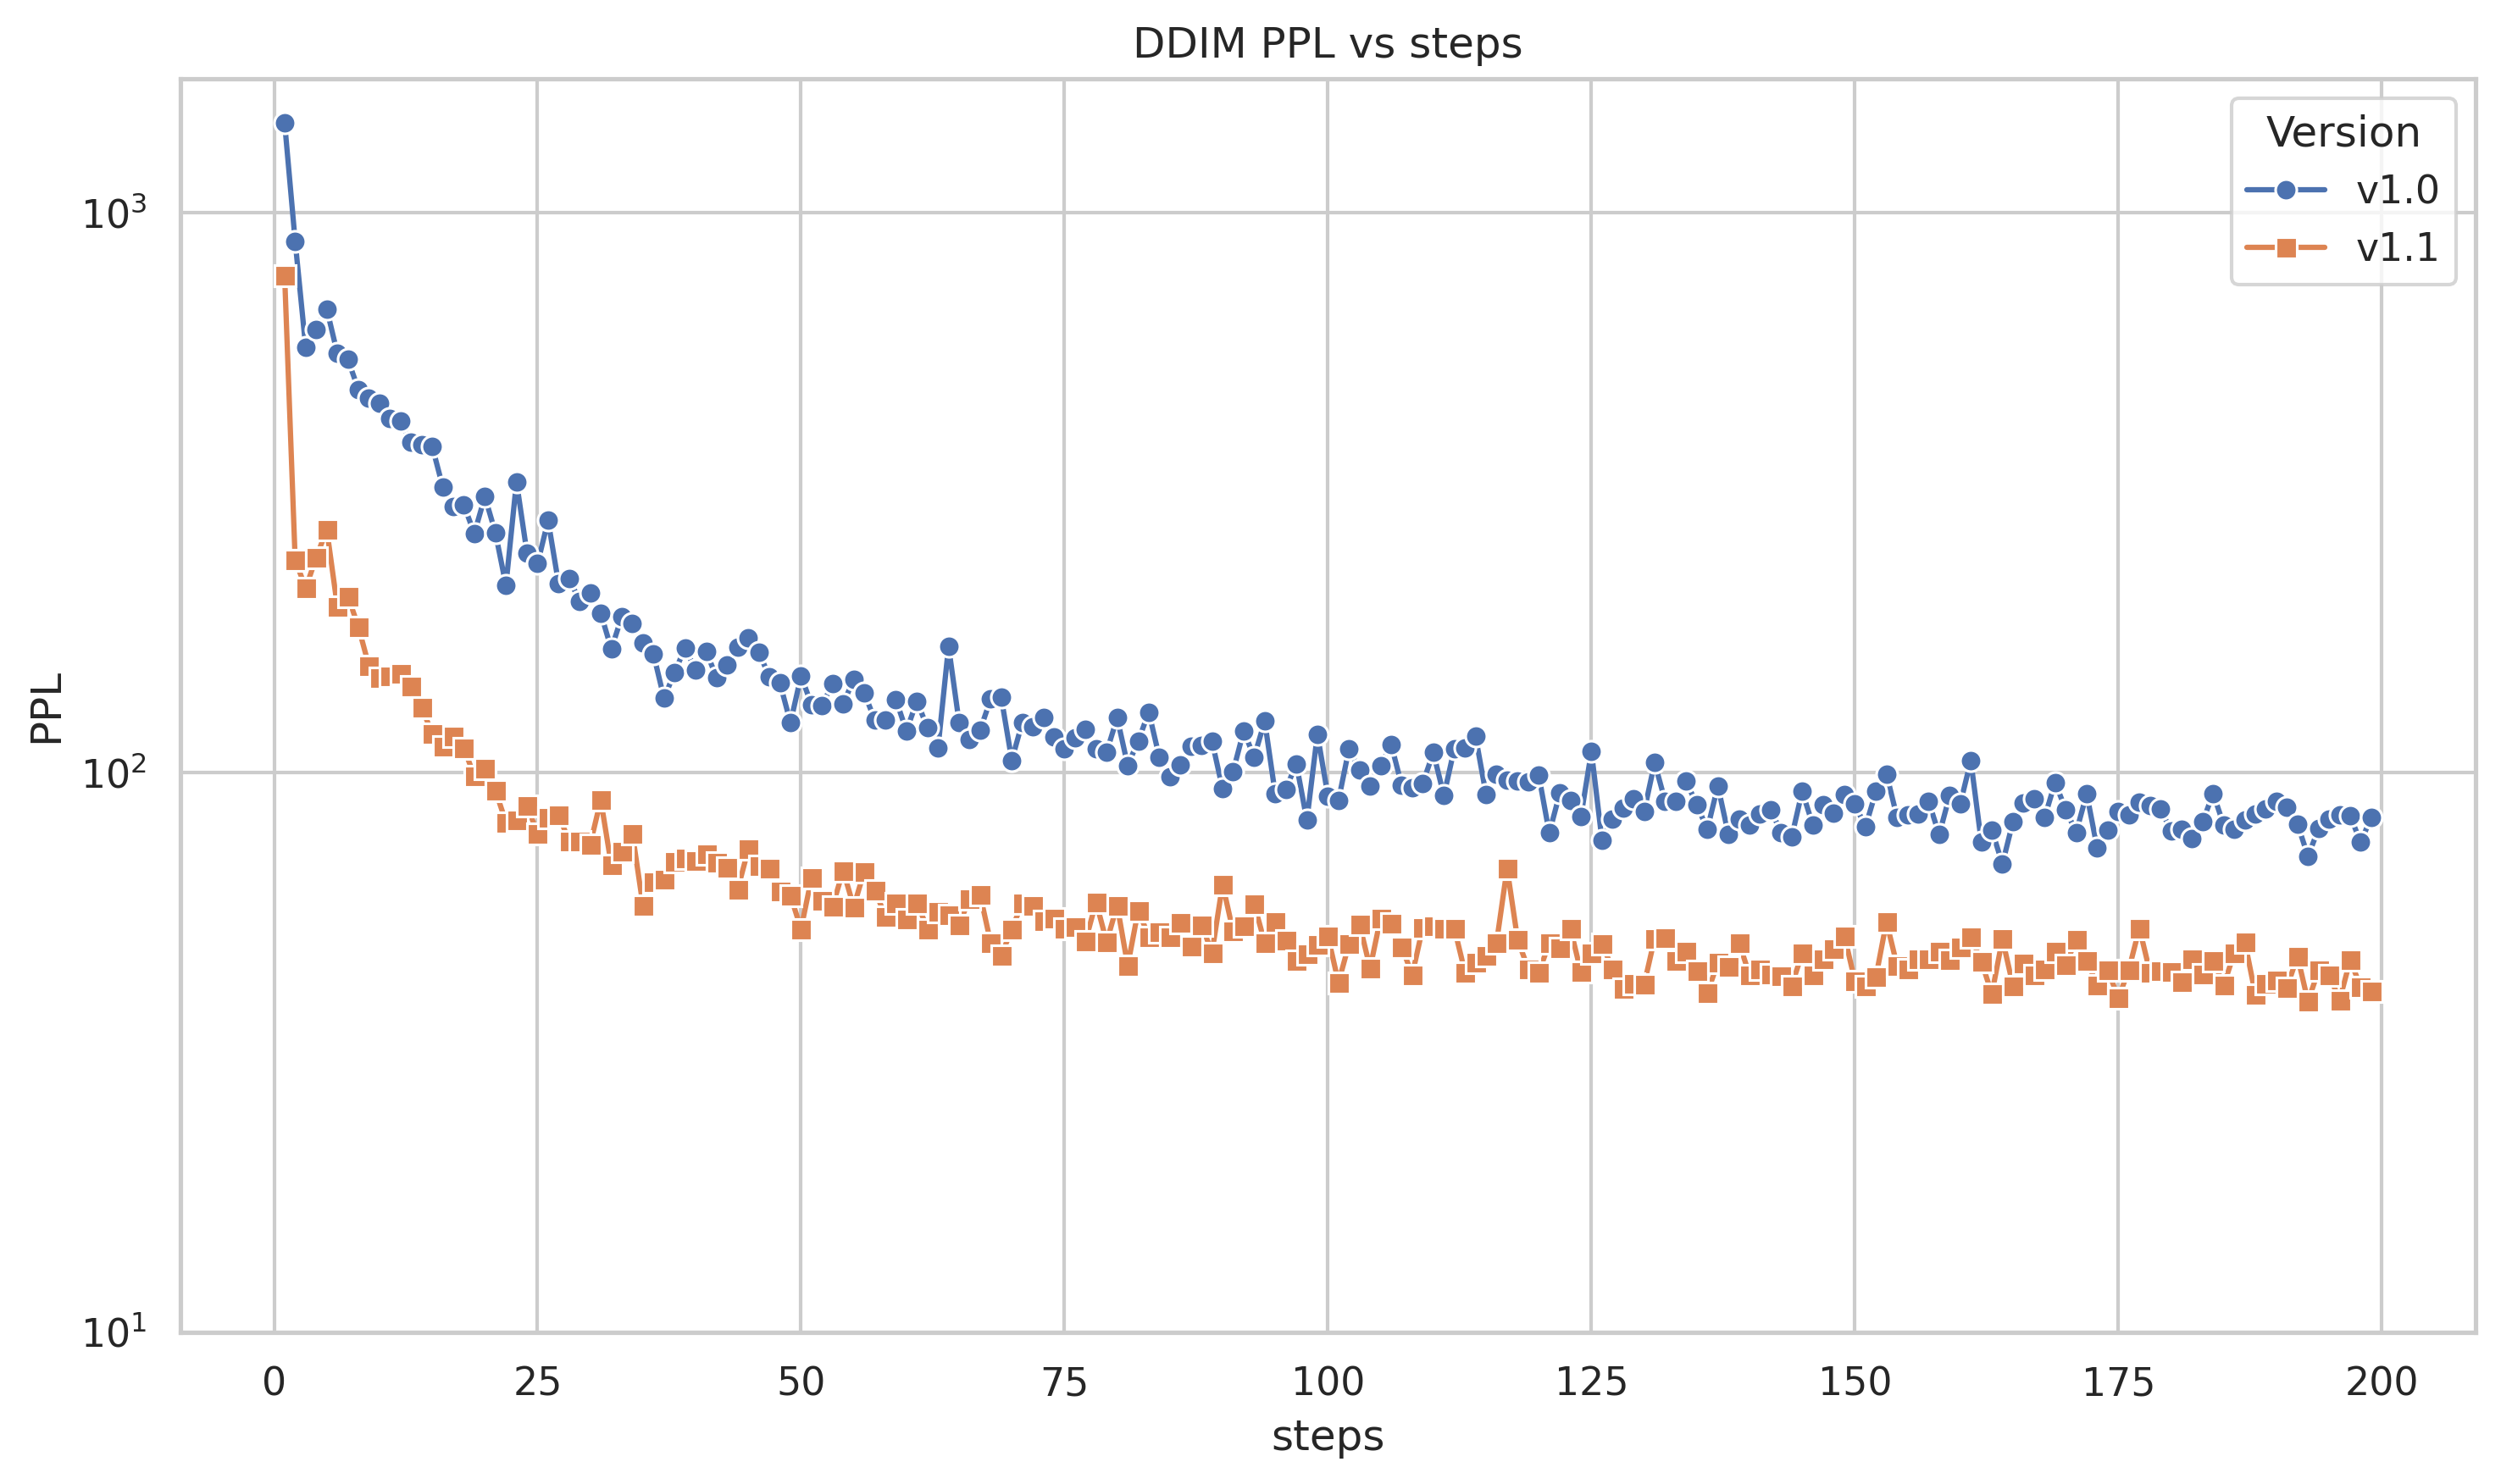

In [94]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme(style="whitegrid")

plt.figure(figsize=(10, 6), dpi=300)
sns.lineplot(data=data_v10_ddim, x="steps", y="ppl", label="v1.0", marker="o")
sns.lineplot(data=data_v11_ddim, x="steps", y="ppl", label="v1.1", marker="s")
plt.yscale('log')
plt.ylim(bottom=1e1)  # start y-axis at 10^1
plt.title("DDIM PPL vs steps")
plt.xlabel("steps")
plt.ylabel("PPL")
plt.legend(title="Version")
plt.tight_layout()
plt.show()

# Diffusion Stability

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


In [11]:
data_v10_stability = pd.read_csv("noise_spike_recovery-diffusion-rocstories-16-d=5-v1.0.csv", index_col=0)
data_v11_stability = pd.read_csv("noise_spike_recovery-diffusion-rocstories-16-d=5-v1.1.csv", index_col=0)

In [13]:
data_v10_stability.index.name = 'std'
data_v11_stability.index.name = 'std'

In [14]:
data_v10_stability

,0.1,0.15,0.2,0.25,0.3,0.35,0.4,0.45,0.5
std,,,,,,,,,
0.05,0.001919,0.002648,0.003335,0.004386,0.005786,0.008473,0.013508,0.033289,0.111050
0.10,0.007688,0.010612,0.013363,0.017533,0.022912,0.032045,0.053495,0.131744,0.382846
0.20,0.030918,0.042761,0.053919,0.070790,0.092279,0.130718,0.205810,0.440309,0.958288
0.50,0.200448,0.281374,0.359176,0.479793,0.629712,0.870849,1.273556,2.289180,3.666697


/tmp/ipykernel_211757/2473888331.py:42: UserWarning: Mismatched number of handles and labels: len(handles) = 6 len(labels) = 4
  legend_std = ax.legend(


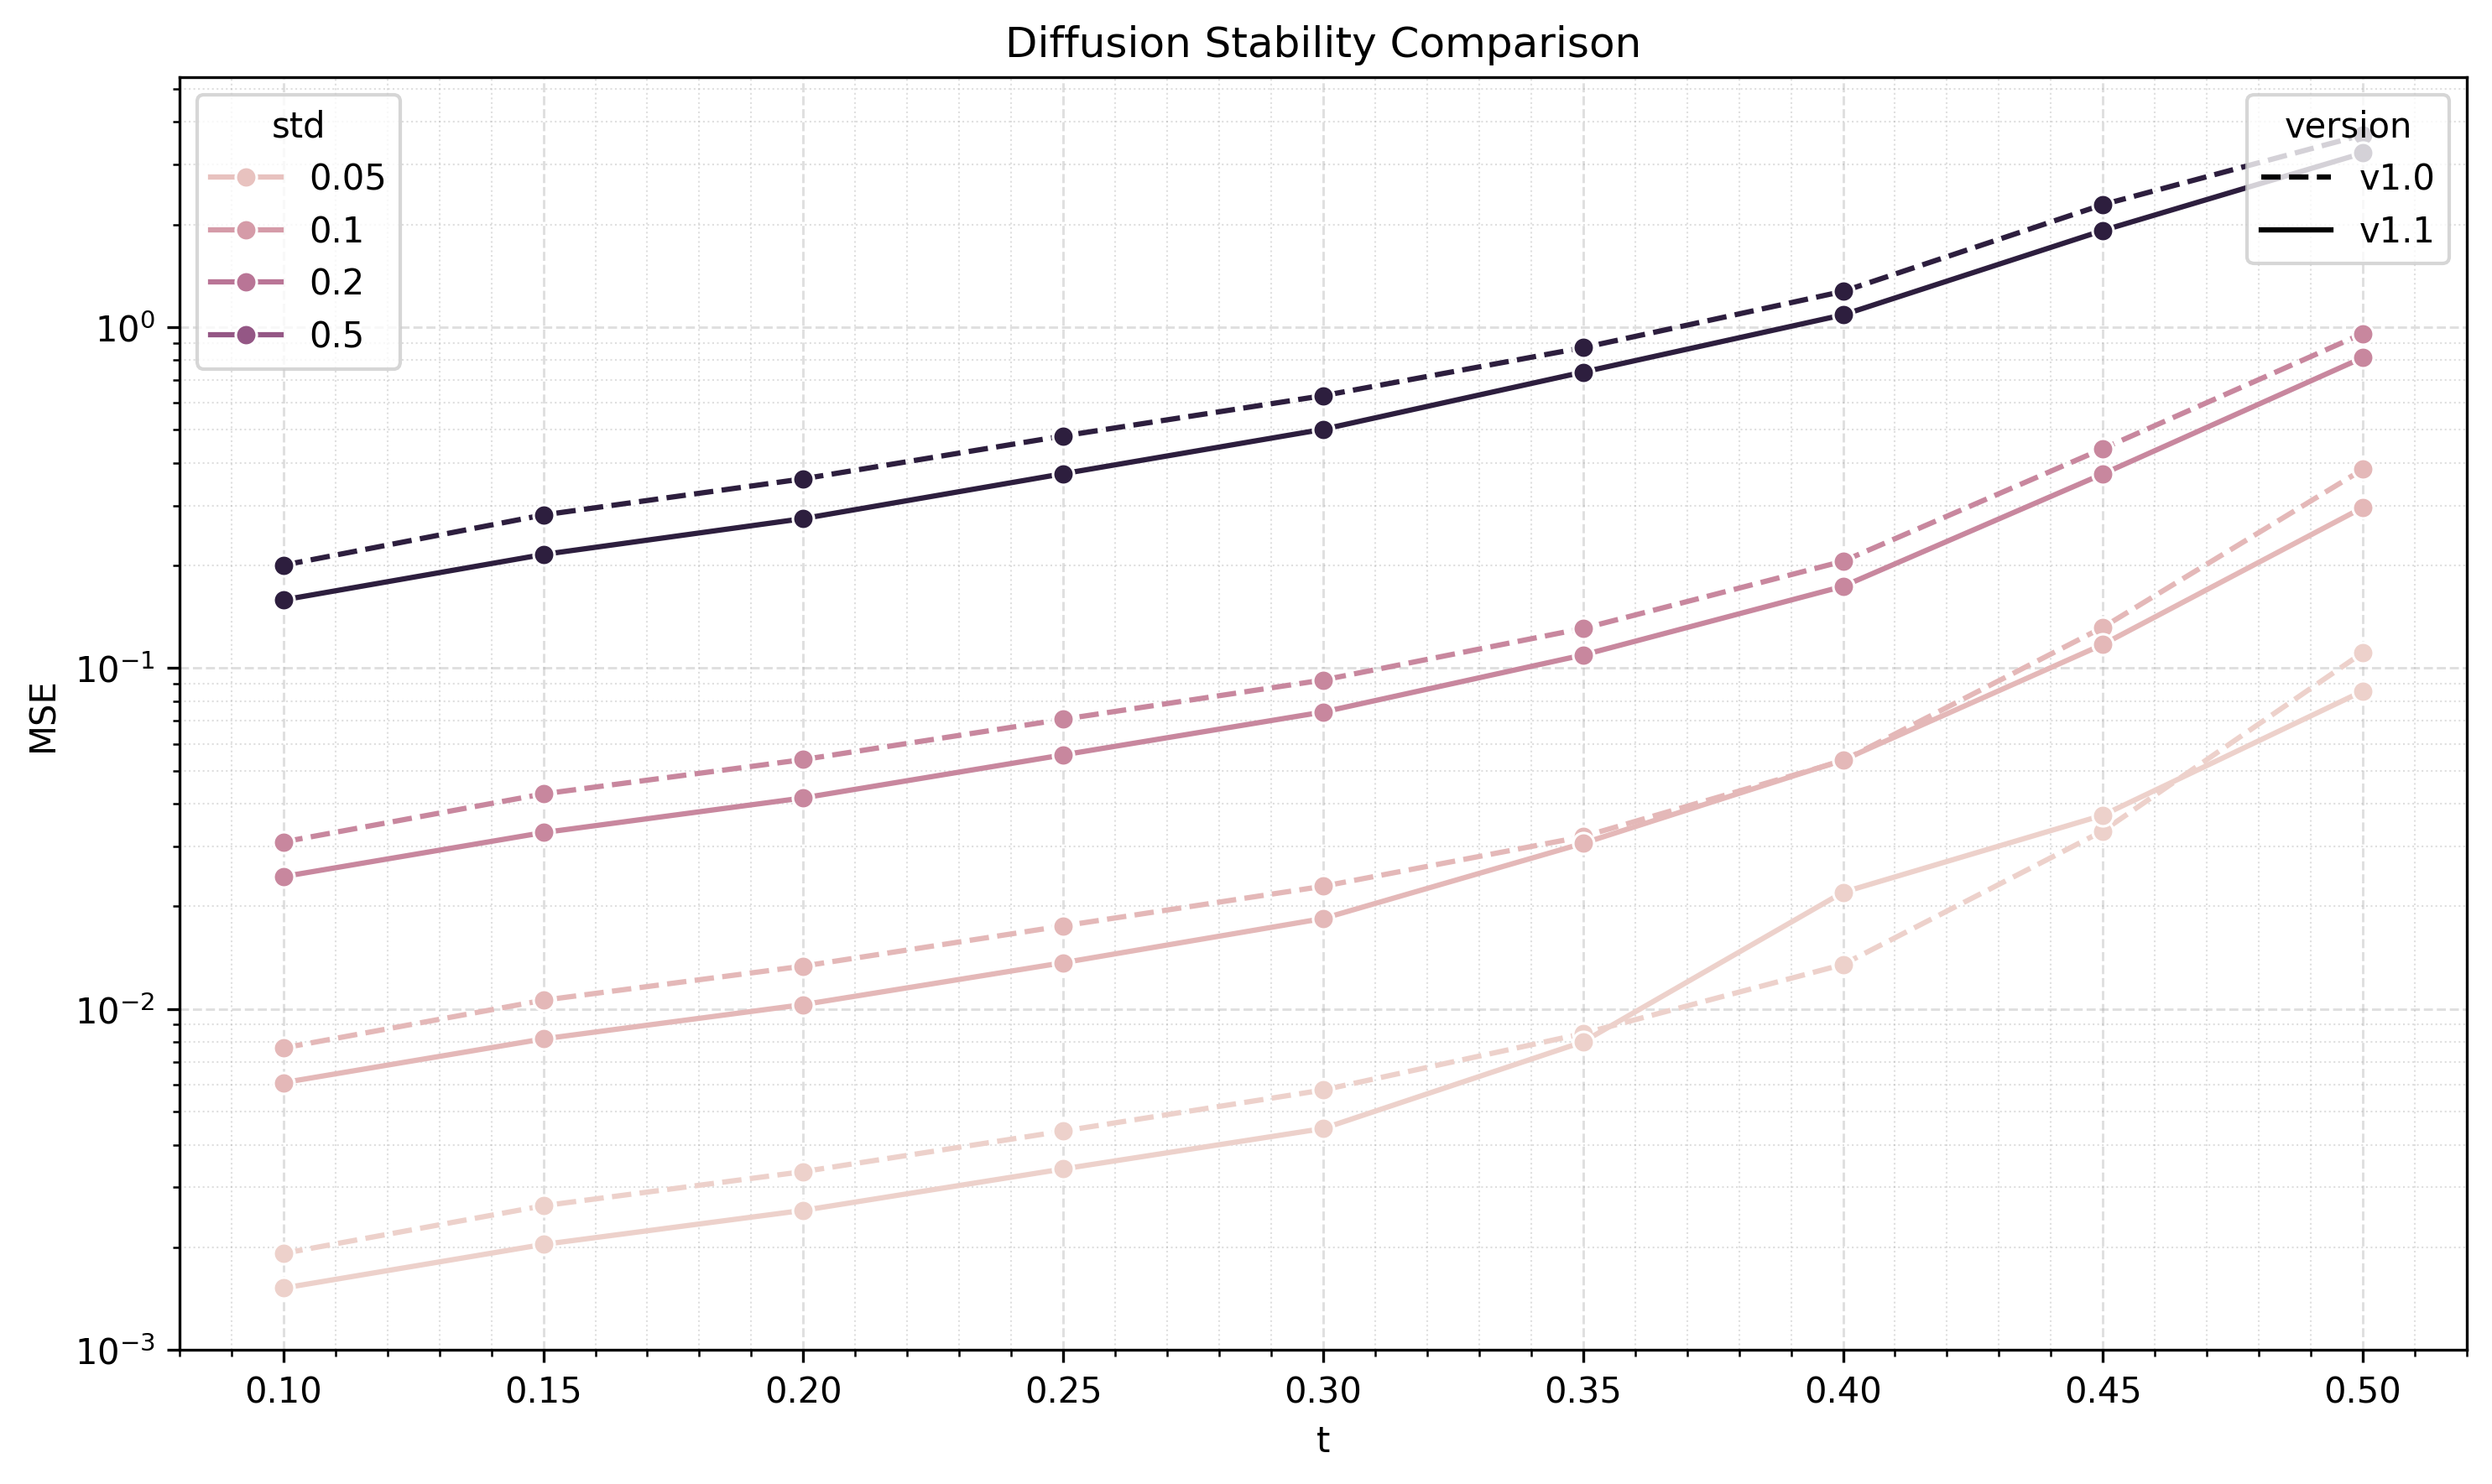

In [22]:

# Melt to long format so we can plot MSE vs t with std as the legend label
df_v10_long = data_v10_stability.reset_index().melt(
    id_vars='std', var_name='t', value_name='MSE'
)
df_v11_long = data_v11_stability.reset_index().melt(
    id_vars='std', var_name='t', value_name='MSE'
)

# Make sure t is numeric
df_v10_long['t'] = df_v10_long['t'].astype(float)
df_v11_long['t'] = df_v11_long['t'].astype(float)

# Single combined plot
fig, ax = plt.subplots(figsize=(10, 6), dpi=300)

# Plot v1.0 with dotted lines (no legend)
sns.lineplot(
    data=df_v10_long,
    x='t', y='MSE', hue='std',
    marker='o', linestyle='--',
    ax=ax, legend=False
)

# Plot v1.1 with solid lines (this will create a std‐hue legend)
sns.lineplot(
    data=df_v11_long,
    x='t', y='MSE', hue='std',
    marker='o', linestyle='-',
    ax=ax, legend='brief'
)

# Add a nice grid (major and minor)
ax.minorticks_on()
ax.grid(which='major', linestyle='--', linewidth=0.7, alpha=0.4)
ax.grid(which='minor', linestyle=':',  linewidth=0.5, alpha=0.4)

# Capture auto‐generated handles and override std labels with data_v11_stability index
std_handles, _ = ax.get_legend_handles_labels()
std_labels = data_v11_stability.index.tolist()

# Draw a framed legend for std values in the upper left
legend_std = ax.legend(
    handles=std_handles,
    labels=std_labels,
    title='std',
    loc='upper left',
    frameon=True
)

# Now add a separate framed legend for version styles in the upper right
from matplotlib.lines import Line2D
version_handles = [
    Line2D([0], [0], color='black', linestyle='--', label='v1.0'),
    Line2D([0], [0], color='black', linestyle='-',  label='v1.1'),
]
legend_version = ax.legend(
    handles=version_handles,
    title='version',
    loc='upper right',
    frameon=True
)

# Re‐add the std legend (since calling a second legend replaces the first)
ax.add_artist(legend_std)

# Final labels and layout
ax.set_title("Diffusion Stability Comparison")
ax.set_xlabel("t")
ax.set_ylabel("MSE")
ax.set_yscale('log')
ax.set_ylim(bottom=1e-3)
plt.tight_layout()
plt.show()



# Robustness

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


In [5]:
data_v10 = pd.read_csv("adversarial-perturbations-autoencoder-num_latents=16-wikipedia-v1.0-128.csv", index_col=0)
data_v11 = pd.read_csv("adversarial-perturbations-autoencoder-num_latents=16-wikipedia-v2.4.2-128.csv", index_col=0)

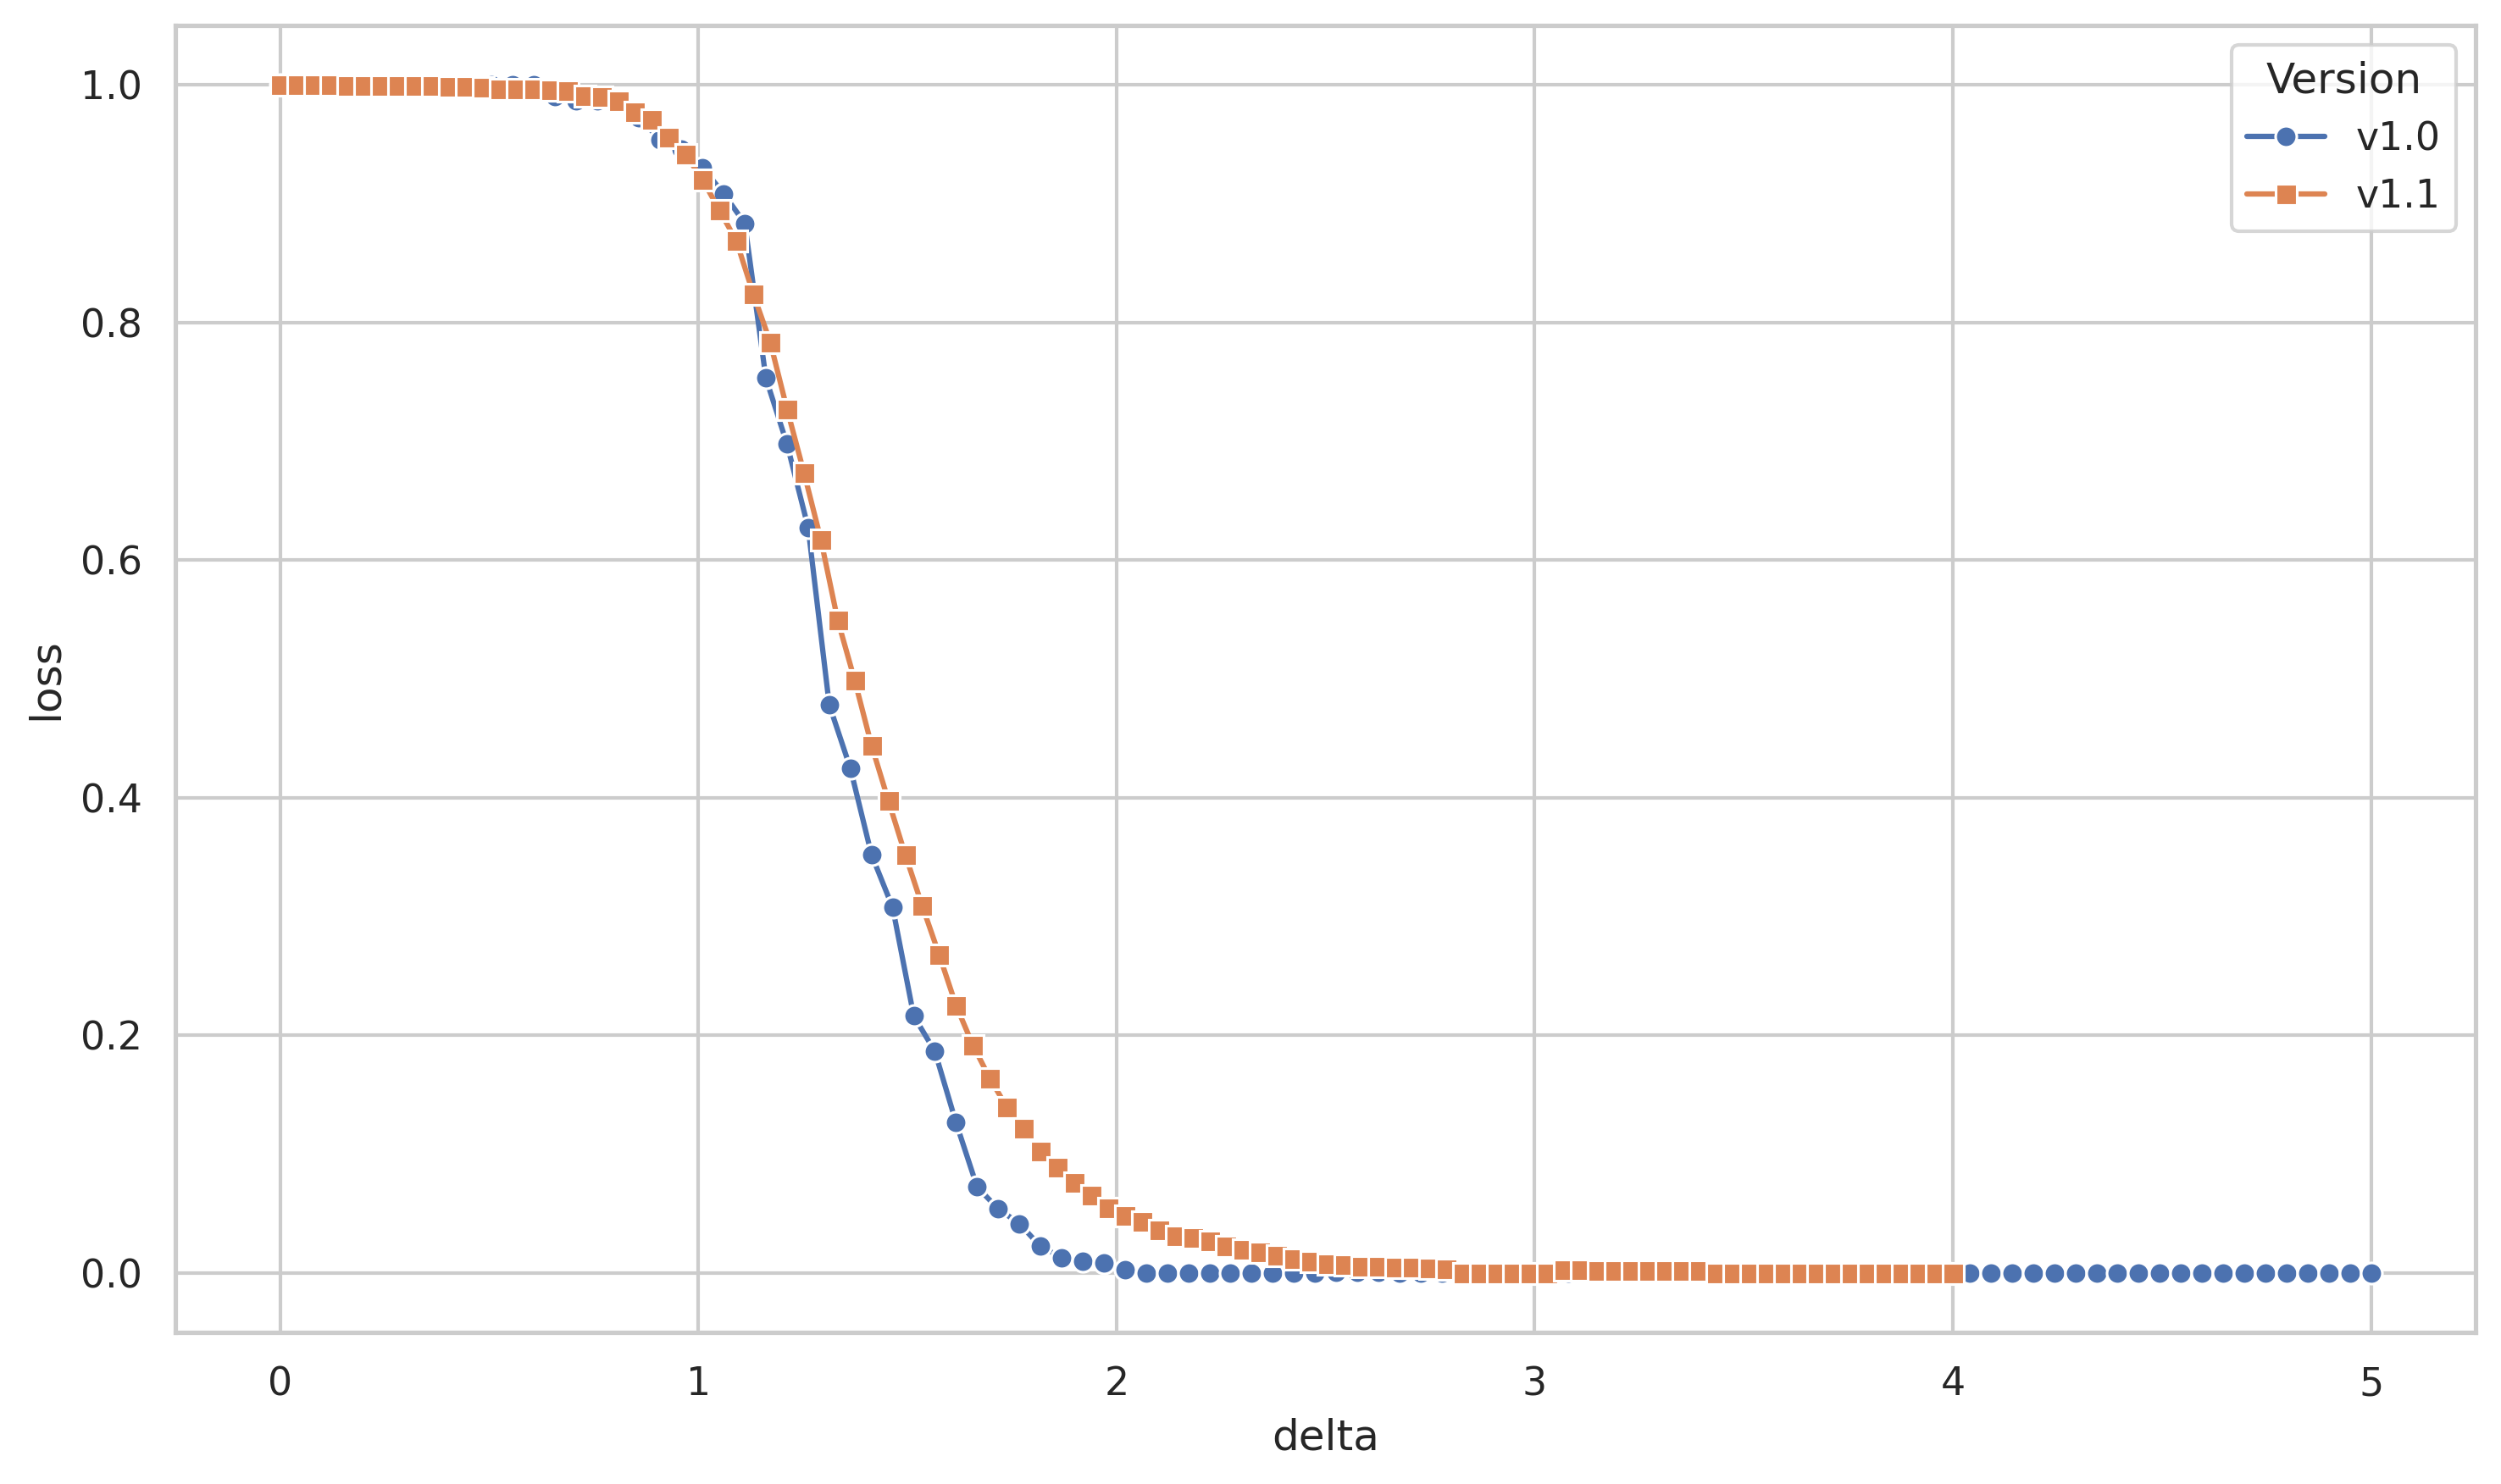

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme(style="whitegrid")

plt.figure(figsize=(10, 6), dpi=300)
sns.lineplot(data=data_v10, x="delta", y="bleu", label="v1.0", marker="o")
sns.lineplot(data=data_v11, x="delta", y="bleu", label="v1.1", marker="s")


plt.xlabel("delta")
plt.ylabel("loss")
plt.legend(title="Version")
plt.tight_layout()
plt.show()